# Final Project of IEOR 4571:TOPICS IN OPERATIONS RESEARCH

Team member:

* Zi Zhuang,  zz2693@columbia.edu
* Jiawen Huang,  jh4179@columbia.edu
*	Hanyu Wu,  hw2753@columbia.edu		                           
*	Liuhaoyue Li,  ll3351@columbia.edu


# Executive Summary
The report provides an analysis and evaluation of a new recommendation system for recommending Top 50 movies to existing valuable users, who have rated over 20 movies. Sequential hybrid models are used, which includes lightFM as basic recommendation algorithm, ANN and a powerful Wide & Deep model as reorder model. Our main evaluation metric is Precision@K and NDCG, but we also consider diversity, novelty and coverage. 

Our recommendation system could beat the original MF and Item-based collaborative filtering model in all metrics we care about. Besides high performance on the same metric, the new system could deal with cold-start problems by combining content information in lightFM and Wide & Deep models. 

Our experiments find the best parameter combination for each model. In order to run cross validation successfully on large dataset, we create seperate scripts to run cross Validation for Deep & Wide model. 

Based on evaluation results, compared with the single model we experimented in last homework, our models performed better.Also, with the help of ANN, we improved the recommendation efficiency. In the end, we trained the whole pipeline in a large dataset and used results as final recommendations. 



#Objective Statement

In order to keep attracting valuable members (we defined them as who watched over 20 movies) and maintain low churn probability, we think building a new recommender system with higher ranking accuracy will benefit our long-term development. At the same time, for the purpose of optimizing the user experience, we want to build an efficient model which could give fast recommendations. Also, this system should be robust and have the ability to handle potential cold-start problems. 

We will recommend personalized Top 50 movies to valuable users in record.  And also, in order to give a better impression with our customers, we will never recommend movies with less than 10 ratings. The reason is: If the item recommended by our recommendation system is only starred by very few people, even if we perfectly solve the long tail problem, the "first impression" of such recommendation results may not be too good for users.

# Evaluation criteria
We will evaluate our recommendation list based on the metrics below. The main evaluation metric is NDCG. And since we aimed to give the best experiences for our end users, all evaluations are tested on the final recommendation list -- the list which excludes movies with less than 10 ratings and movies users have rated before. 

* Normalized discounted cumulative gain. 
NDCG at k is a measure of how many of the first k recommended documents are in the set of true relevant documents averaged across all users. 

  NDCG@k = DCG@kIDCG@k = i=1k2reli - 1log2(i+1)IDCG@k, where IDCG@k is calculated by sorting the ranking by the true unknown relevance (in descending order) and then use the formula for DCG@k.

  Because we will recommend the top 50 movies to each user, so utility-based metrics that take into account both the relevance of an item and its position in the ranking list are better than pure error-based metrics. Also, some studies show NDCG provides the best discriminative power and high robustness ratings to the sparsity bias and moderate robustness to the popularity bias. 


* Precision at K.

  Another ranking metric is Precision at K. It is a measure of how many of the first k recommended movies are in the set of true relevant documents averaged across all users. 

  Precision@k = # of recommended items @k that are relevant# of recommended items @k



* Novelty.

  From the figure of long-tail plot below, we could see there is a long tail of movies’ popularity. So for offline experiments, we could approximate novelty by assuming these popular items are not novel to users. 


* Coverage.

  For coverage metric, we will focus on two specific coverage scores.
 * Catalog-coverage -- The fraction of items that are in the top-k for at least 1 user. 
 * User-coverage -- The percentage of users for whom the recommender was able to generate a recommendation list over the number of potential users.

  We would like to make a model have higher catalog coverage and user coverage. 

* Diversity:

  When recommended to users, we do want to mitigate the filter bubble problem and give some diversity to users. For offline evacuation, we will calculate recommendation lists’ similarity based on items’ embedding we got from lightFM model.  


#Module and Method
There are some standard and customized library we used in this project.

In [ ]:
!pip install funcsigs
!pip install lightfm
!pip install pyspark

import re
import pandas as pd
import numpy as np
import random
import datetime
from collections import Counter
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp
import itertools
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from funcsigs import signature
import warnings
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import auc_score, precision_at_k
from scipy.sparse import csr_matrix
import tensorflow as tf
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.sql import Row, Window
from pyspark.sql.session import SparkSession
from pyspark.ml.evaluation import Evaluator
from pyspark.ml.param.shared import Param
from pyspark.sql.functions import col, expr
import pyspark.sql.functions as F
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml import Pipeline
from pyspark import since, keyword_only
from pyspark.ml import Estimator, Model
from pyspark.ml.common import _py2java
from pyspark.ml.param import Params, Param, TypeConverters
from pyspark.ml.param.shared import HasSeed
from pyspark.ml.util import *
from pyspark.ml.wrapper import JavaParams
from pyspark.sql.functions import rand
from functools import reduce
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.sql.functions import col
from scipy.interpolate import interp1d
from math import log, sqrt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, mean_squared_error

warnings.filterwarnings("ignore")
%matplotlib inline


# !pip install findspark
# import findspark
# findspark.find()


spark = SparkSession\
    .builder\
    .config('spark.driver.memory', '10g')\
    .config('spark.driver.maxResultSize', '8g')\
    .getOrCreate()

In [ ]:
# modified based on https://github.com/statisticianinstilettos/recmetrics.git

class metricPresent():
    def __init__(self, predicted, pop, u, n, catalog, feature_df, actual_list):
        """
        Parameters
        ----------
        predicted : a list of lists
            Ordered predictions
            example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
        pop: dictionary
            A dictionary of all items alongside of its occurrences counter in the training data
            example: {1198: 893, 1270: 876, 593: 876, 2762: 867}
        u: integer
            The number of users in the training data
        n: integer
            The length of recommended lists per user
        catalog: list
            A list of all unique items in the training data
            example: ['A', 'B', 'C', 'X', 'Y', Z]
        feature_df: dataframe
            A dataframe with one hot encoded or latent features.
            The dataframe should be indexed by the id used in the recommendations.
        """
        self.predicted = predicted
        self.pop = pop
        self.u = u
        self.n = n
        self.catalog = catalog
        self.feature_df = feature_df
        self.actual_list = actual_list

    @property
    def novelty(self):
        """
        Computes the novelty for a list of recommendations
        Returns
        ----------
        novelty:
            The novelty of the recommendations in system level
        mean_self_information:
            The novelty of the recommendations in recommended top-N list level
        ----------    
        Metric Defintion:
        Zhou, T., Kuscsik, Z., Liu, J. G., Medo, M., Wakeling, J. R., & Zhang, Y. C. (2010).
        Solving the apparent diversity-accuracy dilemma of recommender systems.
        Proceedings of the National Academy of Sciences, 107(10), 4511-4515.
        """
        mean_self_information = []
        k = 0
        for sublist in self.predicted:
            self_information = 0
            k += 1
            for i in sublist:
                try:
                    self_information += np.sum(-np.log2(self.pop[i]/self.u))
                except:
                    continue
            mean_self_information.append(self_information/self.n)
        novelty = sum(mean_self_information)/k
        return novelty, mean_self_information

    @property
    def prediction_coverage(self):
        """
        Computes the prediction coverage for a list of recommendations
        Returns
        ----------
        prediction_coverage:
            The prediction coverage of the recommendations as a percent
            rounded to 2 decimal places
        ----------    
        Metric Defintion:
        Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
        Beyond accuracy: evaluating recommender systems by coverage and serendipity.
        In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
        """
        predicted_flattened = [
            p for sublist in self.predicted for p in sublist]
        unique_predictions = len(set(predicted_flattened))
        prediction_coverage = round(
            unique_predictions/(len(self.catalog) * 1.0)*100, 2)
        return prediction_coverage

    @property
    def personalization(self):
        """
        Personalization measures recommendation similarity across users.
        A high score indicates good personalization (user's lists of recommendations are different).
        A low score indicates poor personalization (user's lists of recommendations are very similar).
        A model is "personalizing" well if the set of recommendations for each user is different.
        Parameters:
        ----------
        predicted : a list of lists
            Ordered predictions
            example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
        Returns:
        -------
            The personalization score for all recommendations.
        """

        def make_rec_matrix(predicted):
            df = pd.DataFrame(data=predicted).reset_index().melt(
                id_vars='index', value_name='item',
            )

            df['item'] = df['item'].astype(str)

            df = df[['index', 'item']].pivot(
                index='index', columns='item', values='item')

            df = pd.notna(df)*1
            rec_matrix = sp.csr_matrix(df.values)
            return rec_matrix

        # create matrix for recommendations
        predicted = np.array(self.predicted)
        rec_matrix_sparse = make_rec_matrix(predicted)

        # calculate similarity for every user's recommendation list
        similarity = cosine_similarity(X=rec_matrix_sparse, dense_output=False)

        # get indicies for upper right triangle w/o diagonal
        upper_right = np.triu_indices(similarity.shape[0], k=1)

        # calculate average similarity
        personalization = np.mean(similarity[upper_right])
        return 1-personalization

    def _single_list_similarity(self, predicted, feature_df, u):
        """
        Computes the intra-list similarity for a single list of recommendations.
        Parameters
        ----------
        predicted : a list
            Ordered predictions
            Example: ['X', 'Y', 'Z']
        feature_df: dataframe
            A dataframe with one hot encoded or latent features.
            The dataframe should be indexed by the id used in the recommendations.
        Returns:
        -------
        ils_single_user: float
            The intra-list similarity for a single list of recommendations.
        """
        # exception predicted list empty
        if not(predicted):
            raise Exception('Predicted list is empty, index: {0}'.format(u))

        # get features for all recommended items

        recs_content = feature_df.loc[feature_df.index.intersection(predicted)]

        recs_content = np.array([np.array(x[0]) for x in recs_content.values])

        # calculate similarity scores for all items in list
        similarity = cosine_similarity(X=recs_content, dense_output=False)

        # get indicies for upper right triangle w/o diagonal
        upper_right = np.triu_indices(similarity.shape[0], k=1)

        # calculate average similarity score of all recommended items in list
        ils_single_user = np.mean(similarity[upper_right])
        return ils_single_user

    @property
    def intra_list_similarity(self):
        """
        Computes the average intra-list similarity of all recommendations.
        This metric can be used to measure diversity of the list of recommended items.
        Returns:
        -------
            The average intra-list similarity for recommendations.
        """
        feature_df = self.feature_df.fillna(0)
        Users = range(len(self.predicted))
        ils = [self._single_list_similarity(
            self.predicted[u], feature_df, u) for u in Users]
        return np.mean(ils)

    @property
    def user_coverage(self):
        def calc_user_coverage(predicted, actual):
            reca = [value for value in predicted if value in actual]
            if len(reca) > 1:
                return 1
            else:
                return 0
        user_coverage = np.sum(list(
            map(calc_user_coverage, self.predicted, self.actual_list)))/len(self.actual_list)

        return user_coverage

    # def user_coverage(self,predicted,user_number):
    #     return round(len(predicted)/user_number,2)

In [ ]:
def long_tail_plot(df, item_id_column, interaction_type, percentage=None, x_labels=True):
    """
        Plots the long tail for a user-item interaction dataset.
        ----------
        df: pandas dataframe
            user-item interaction dataframe
            example:
        item_id_column: str
            column name identifying the item ids in the dataframe
        interaction_type: str
            type of user-item interactions
            i.e. 'purchases', 'ratings' 'interactions', or 'clicks'
        percentage: float, default=None
            percent of volume to consider as the head (percent as a decimal)
            (if default=None no line will be plotted)
        x_tables bool, default=True
            if True, plot x-axis tick labels
            if False, no x-axis tick lavels will be plotted.
        Returns:
        -------
            A long tail plot
        """
    # calculate cumulative volumes
    volume_df = pd.DataFrame(df[item_id_column].value_counts())
    volume_df.reset_index(inplace=True)
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume'] / \
        volume_df['volume'].sum()

    # line plot of cumulative volume
    x = range(0, len(volume_df))
    ax = sns.lineplot(x, y="volume", data=volume_df, color="black")
    plt.xticks(x)

    # set labels
    ax.set_title('Long Tail Plot')
    ax.set_ylabel('# of ' + interaction_type)
    ax.set_xlabel(item_id_column)

    if percentage != None:
        # plot vertical line at the tail location
        head = volume_df[volume_df.percent_of_total_volume <= percentage]
        tail = volume_df[volume_df.percent_of_total_volume > percentage]
        items_in_head = len(head)
        items_in_tail = len(tail)
        plt.axvline(x=items_in_head, color="red",  linestyle='--')

        # fill area under plot
        head = head.append(tail.head(1))
        x1 = head.index.values
        y1 = head['volume']
        x2 = tail.index.values
        y2 = tail['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.2)
        ax.fill_between(x2, y2,  color="orange", alpha=0.2)

        # create legend
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': items in the head', markerfacecolor='blue', markersize=5),
                           Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': items in the tail', markerfacecolor='orange', markersize=5)]
        ax.legend(handles=legend_elements, loc=1)

    else:
        x1 = volume_df[item_id_column]
        y1 = volume_df['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.3)
    if x_labels == False:
        plt.xticks([], [])
        ax.set(xticklabels=[])
    else:
        ax.set_xticklabels(
            labels=volume_df[item_id_column], rotation=45, ha="right")

    plt.show()

In [ ]:
class metricPlot():
    def __init__(self, model_names, NDCG_scores, precisionTopk_scores,
                 coverage_scores, user_coverage_scores, personalization_scores,
                 novelty_scores, intra_list_similarity_scores):
        """
        Plots the metric plots for a set of models to compare.
        ----------
        model_names: list
            list of model names in same order as coverage_scores
            example: ['Model A', 'Model B', 'Model C']
        NDCG_scores: list
            list of NDCG scores in same order as model_names
            example: [0.13, 0.52, 0.36]
        precisionTopk_scores: list
            list of precisionTopk scores in same order as model_names
            example: [0.13, 0.52, 0.36]
        accuracy: list
            list of accuracy scores in same order as model_names
            example: [0.13, 0.52, 0.36]
        coverage_scores: list
            list of coverage scores in same order as model_names
            example: [0.17, 0.25, 0.76]
        user_coverage_scores: list
            list of user coverage scores in same order as model_names
            example: [0.17, 0.25, 0.76]
        personalization_scores: list
            list of personalization scores in same order as model_names
            example: [0.13, 0.52, 0.36]
        novelty_scores: list
            list of novelty scores in same order as model_names
            example: [0.13, 0.52, 0.36]
        intra_list_similarity_scores: list
            list of intra-list similarity scores in same order as model_names
            example: [0.13, 0.52, 0.36]
        """
        self.model_names = model_names
        self.NDCG_scores = NDCG_scores
        self.precisionTopk_scores = precisionTopk_scores
        # self.accuracy=accuracy
        self.coverage_scores = coverage_scores
        self.user_coverage_scores = user_coverage_scores
        self.personalization_scores = personalization_scores
        self.novelty_scores = novelty_scores
        self.intra_list_similarity_scores = intra_list_similarity_scores

    @staticmethod
    def show_values_on_bars(axs, h_v="v", space=0.4):
        def _show_on_single_plot(ax):
            if h_v == "v":
                for p in ax.patches:
                    _x = p.get_x() + p.get_width() / 2
                    _y = p.get_y() + p.get_height()
                    value = round(p.get_height(), 4)
                    ax.text(_x, _y, value, ha="center")
            elif h_v == "h":
                for p in ax.patches:
                    _x = p.get_x() + p.get_width() + float(space)
                    _y = p.get_y() + p.get_height()
                    value = round(p.get_height(), 4)
                    ax.text(_x, _y, value, ha="left")

        if isinstance(axs, np.ndarray):
            for idx, ax in np.ndenumerate(axs):
                _show_on_single_plot(ax)
        else:
            _show_on_single_plot(axs)

    @property
    def NDCG_plot(self):
        """
        Plots the NDCG for a set of models to compare.
        ----------
        Returns:
        -------
            A NDCG plot
        """
        # create palette
        plt.figure(figsize=(12, 6))
        recommender_palette = ["#ED2BFF", "#14E2C0",
                               "#FF9F1C", "#5E2BFF", "#FC5FA3"]
        sns.set_palette(recommender_palette)
        # make barplot
        ax = sns.barplot(x=self.model_names, y=self.NDCG_scores)
        # set labels
        ax.set_title("NDCG@50")
        ax.set_ylabel("NDCG@50")
        self.show_values_on_bars(ax)
        plt.show()

    @property
    def precisionTopk_plot(self):
        """
        Plots the precisionTopk for a set of models to compare.
        ----------
        Returns:
        -------
            A precisionTopk plot
        """
        # create palette
        plt.figure(figsize=(12, 6))
        recommender_palette = ["#ED2BFF", "#14E2C0",
                               "#FF9F1C", "#5E2BFF", "#FC5FA3"]
        sns.set_palette(recommender_palette)
        # make barplot
        ax = sns.barplot(x=self.model_names, y=self.precisionTopk_scores)
        # set labels
        ax.set_title("precision@50")
        ax.set_ylabel("precision@50")
        self.show_values_on_bars(ax)
        plt.show()

    @property
    def accuracy_plot(self):
        """
        Plots the accuracy for a set of models to compare.
        ----------
        Returns:
        -------
            A accuracy plot
        """
        # create palette
        plt.figure(figsize=(12, 6))
        recommender_palette = ["#ED2BFF", "#14E2C0",
                               "#FF9F1C", "#5E2BFF", "#FC5FA3"]
        sns.set_palette(recommender_palette)
        # make barplot
        ax = sns.barplot(x=self.model_names, y=self.accuracy_scores)
        # set labels
        ax.set_title(" rmse ")
        ax.set_ylabel(" rmse")
        self.show_values_on_bars(ax)
        plt.show()

    @property
    def coverage_plot(self):
        """
        Plots the coverage for a set of models to compare.
        ----------
        Returns:
        -------
            A coverage plot
        """
        # create palette
        plt.figure(figsize=(12, 6))
        recommender_palette = ["#ED2BFF", "#14E2C0",
                               "#FF9F1C", "#5E2BFF", "#FC5FA3"]
        sns.set_palette(recommender_palette)
        # make barplot
        ax = sns.barplot(x=self.model_names, y=self.coverage_scores)
        # set labels
        ax.set_title('Catalog Coverage in %')
        ax.set_ylabel('coverage')
        self.show_values_on_bars(ax)
        plt.show()

    @property
    def user_coverage_plot(self):
        """
        Plots the coverage for a set of models to compare.
        ----------
        Returns:
        -------
            A coverage plot
        """
        plt.figure(figsize=(12, 6))
        # create palette
        recommender_palette = ["#ED2BFF", "#14E2C0",
                               "#FF9F1C", "#5E2BFF", "#FC5FA3"]
        sns.set_palette(recommender_palette)
        # make barplot
        ax = sns.barplot(x=self.model_names, y=self.user_coverage_scores)
        # set labels
        ax.set_title('User Coverage in %')
        ax.set_ylabel('coverage')
        self.show_values_on_bars(ax)
        plt.show()

    @property
    def personalization_plot(self):
        """
        Plots the personalization for a set of models to compare.
        ----------
        Returns:
        -------
            A personalization plot
        """
        # create palette
        plt.figure(figsize=(12, 6))
        recommender_palette = ["#ED2BFF", "#14E2C0",
                               "#FF9F1C", "#5E2BFF", "#FC5FA3"]
        sns.set_palette(recommender_palette)
        # make barplot
        ax = sns.barplot(x=self.model_names, y=self.personalization_scores)
        # set labels
        ax.set_title("Personalization in %")
        ax.set_ylabel("personalization")
        self.show_values_on_bars(ax)
        plt.show()

    @property
    def novelty_plot(self):
        """
        Plots the novelty for a set of models to compare.
        ----------
        Returns:
        -------
            A novelty plot
        """
        # create palette
        plt.figure(figsize=(12, 6))
        recommender_palette = ["#ED2BFF", "#14E2C0",
                               "#FF9F1C", "#5E2BFF", "#FC5FA3"]
        sns.set_palette(recommender_palette)
        # make barplot
        ax = sns.barplot(x=self.model_names, y=self.novelty_scores)
        # set labels
        ax.set_title("novelty")
        ax.set_ylabel("novelty")
        # self.show_values_on_bars(ax)
        plt.show()

    @property
    def intra_list_similarity_plot(self):
        """
        Plots the intra-list similarity for a set of models to compare.
        ----------
        Returns:
        -------
            A intra-list similarity plot
        """
        # create palette
        plt.figure(figsize=(12, 6))
        recommender_palette = ["#ED2BFF", "#14E2C0",
                               "#FF9F1C", "#5E2BFF", "#FC5FA3"]
        sns.set_palette(recommender_palette)
        # make barplot
        ax = sns.barplot(x=self.model_names,
                         y=self.intra_list_similarity_scores)
        # set labels
        ax.set_title("Diversity in %")
        ax.set_ylabel("Diversity in %")
        self.show_values_on_bars(ax)
        plt.show()

    def make_listy(p):
        if isinstance(p, str):
            return [p]
        try:
            _ = iter(p)
        except TypeError:
            p = [p]
        return p

    def is_listy(x): return isinstance(x, (tuple, list))

    @property
    def metrics_plot(self):
        """
        Plots the coverage, personalization and intra-list similarity for a set of models to compare.
        ----------
        Returns:
        -------
            An interactive metrics plot
        """

        fig = go.Figure()

        for model_name, coverage, personalization, intra_list_similarity in \
            zip(self.model_names, self.coverage_scores, self.personalization_scores,
                self.intra_list_similarity_scores):
            fig.add_trace(go.Scatterpolar(
                r=[coverage, personalization * 100, intra_list_similarity * 100],
                theta=['coverage', 'personalization', 'diversity'],
                fill='tonext',
                name=model_name
            ))

        fig.update_layout(
            polar=dict(
                radialaxis=dict(
                    visible=True,
                    range=[0, 100]
                )),
            showlegend=True
        )

        fig.show()

#Sampling

Requirement for different usages:
1. at least 20,000 users and 1,000 items (larger dataset for the project)
2. about 1,000 users and 200 items (smaller dataset for development)

Choices:
1. Do you care about choosing popular items or unpopular items?
> We want to accomodate both popular and unpopular item with reasonable propoertion in our samples, so we can recommend popular item and at the same time keep novelty. For this reason, we decide to randomly choose items first ignoring how many people rate them, so items in the sample will include randomness. Howerver, considering the development of models, we want these items having at least a minimum number of ratings (for example, each movie must have at least 20 ratings for the larger dataset).

2. Do you care about how many items a user has rated?
> We will only choose users that rate at least a minimum number of items to get a relative dense matrix (for example if we need to create a sample having at least 20,000 users and 1,000 items, each users we choose must have rated at least 20 items). 

3. If you merely sample rows randomly from the raw data set, will you be missing relevant data for samples users or items?
> Yes, we have already solved this problem in the first two questions.

Full Dataset Description:
1. 27753444 ratings
2. 1108997 tag applications
3. 58098 movies
4. 283228 users

We do not want to leverage any information about test data, so we sample our development dataset only from the train dataset part of the larger dataset.



In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest.zip
!unzip ml-latest.zip
!ls ./ml-latest
full_dir = "./ml-latest/"
full_movies = pd.read_csv(full_dir+'movies.csv')
full_ratings = pd.read_csv(full_dir+'ratings.csv')
full_tags = pd.read_csv(full_dir+'tags.csv')
full_genome_scores = pd.read_csv(full_dir+'genome-scores.csv')
full_genome_tags = pd.read_csv(full_dir+'genome-tags.csv')

--2020-12-17 17:37:07--  http://files.grouplens.org/datasets/movielens/ml-latest.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 277113433 (264M) [application/zip]
Saving to: ‘ml-latest.zip’

ml-latest.zip       100%[===================>] 264.28M  59.2MB/s    in 4.8s    

2020-12-17 17:37:12 (55.2 MB/s) - ‘ml-latest.zip’ saved [277113433/277113433]

Archive:  ml-latest.zip
   creating: ml-latest/
  inflating: ml-latest/links.csv     
  inflating: ml-latest/tags.csv      
  inflating: ml-latest/genome-tags.csv  
  inflating: ml-latest/ratings.csv   
  inflating: ml-latest/README.txt    
  inflating: ml-latest/genome-scores.csv  
  inflating: ml-latest/movies.csv    
genome-scores.csv  links.csv   ratings.csv  tags.csv
genome-tags.csv    movies.csv  README.txt


In [ ]:
sample_items_users = pd.merge(full_movies,full_ratings, how = 'left', on = ['movieId'])

def sample_dataset(full_ratings,min_movie_ratings,min_user_ratings,num_user,num_item):
    random.seed(1)
    sample_items_counts = full_ratings['movieId'].value_counts()>=min_movie_ratings
    sample_items_true = random.sample(list(sample_items_counts[sample_items_counts==True].index),int(num_item*1.3))
    sample_items_users_new1 = full_ratings[full_ratings['movieId'].isin(sample_items_true)]
    sample_users_counts = sample_items_users_new1['userId'].value_counts()>=min_user_ratings
    sample_users_true = random.sample(list(sample_users_counts[sample_users_counts==True].index),int(num_user*1.001))
    sample_items_users_new2 = sample_items_users_new1[sample_items_users_new1['userId'].isin(sample_users_true)]
    sample_items_counts = sample_items_users_new2['movieId'].value_counts()>=min_movie_ratings
    sample_items_true = list(sample_items_counts[sample_items_counts==True].index)
    sample_items_users_new3 = sample_items_users_new2[sample_items_users_new2['movieId'].isin(sample_items_true)]
    return sample_items_users_new3

larger_dataset = sample_dataset(sample_items_users,20,20,20000,1000)
# larger_dataset.head()

## Train Test Split

For recommender systems, withholding data means withholding user-item pairs. it does not mean holding out a subset of users, or a subset of items,
but what if this kind of method creates cold start users or items? 

Our sampling approaches seek to minimize this possibility:

> 1. we have built the algorithm using only users or items with a minimum number of interactions


> 2. we leave out the latest interactions of each user to form the test dataset 

We also found that in our larger dataset there are users who have rated multiple movies at the same time, so we only keep the number of records we want as the test dataset in this case.

In [ ]:
def build_train_test_split(full, if_develop=False):
    random.seed(1)
    if if_develop==True:
        new = full.copy()
        test = pd.DataFrame()
        for i in range(2):
            latest_timestamp = new.groupby('userId').timestamp.max().rename('latest')
            temp = pd.merge(latest_timestamp, new, how='inner', left_index=True, right_on='userId')
            test_ = temp[temp['latest']==temp['timestamp']]
            test_.drop(['latest'],axis=1,inplace=True)
            test_ = test_.drop_duplicates(subset=['userId'],keep='first')
            test = pd.concat([test, test_])
            new = new[~new.index.isin(test_.index)]
        train = full[~full.index.isin(test.index)].dropna()
    else:
        new = full.copy()
        test = pd.DataFrame()
        for i in range(5):
            latest_timestamp = new.groupby('userId').timestamp.max().rename('latest')
            temp = pd.merge(latest_timestamp, new, how='inner', left_index=True, right_on='userId')
            test_ = temp[temp['latest']==temp['timestamp']]
            test_.drop(['latest'],axis=1,inplace=True)
            test_ = test_.drop_duplicates(subset=['userId'],keep='first')
            test = pd.concat([test, test_])
            new = new[~new.index.isin(test_.index)]
        train = full[~full.index.isin(test.index)].dropna()
    return train, test

In [ ]:
def kfold(dataset, n_splits=3):
    """ Iterate from the output of the function could we get n sets of train and test data"""
    kfold_list = list()
    stratifiedKFolds = StratifiedKFold(n_splits=n_splits, shuffle=False)
    for i, (trn_idx, val_idx) in enumerate(stratifiedKFolds.split(dataset, dataset.userId)):
        train = dataset.reset_index().iloc[trn_idx].set_index('index')
        train.index.name = None
        test = dataset.reset_index().iloc[val_idx].set_index('index')
        test.index.name = None
        kfold_list.append((train, test))
    # kfold_list is a list, length of n_splits. [(train_0, test_0), (train_1, test_1), (train_2, test_2)]
    return kfold_list

# kfold_dataset = kfold(larger_dataset, 3)

In [ ]:
train, test = build_train_test_split(larger_dataset)
development_dataset = sample_dataset(larger_dataset,5,12,1000,200)
# development_dataset.head()

In [ ]:
full_dataset = pd.concat([train, test])

# EDA

First we explored the Long tail effect. We could see the distribution of movies popularity is long tail. Most of movies are rated by smaller set of people.

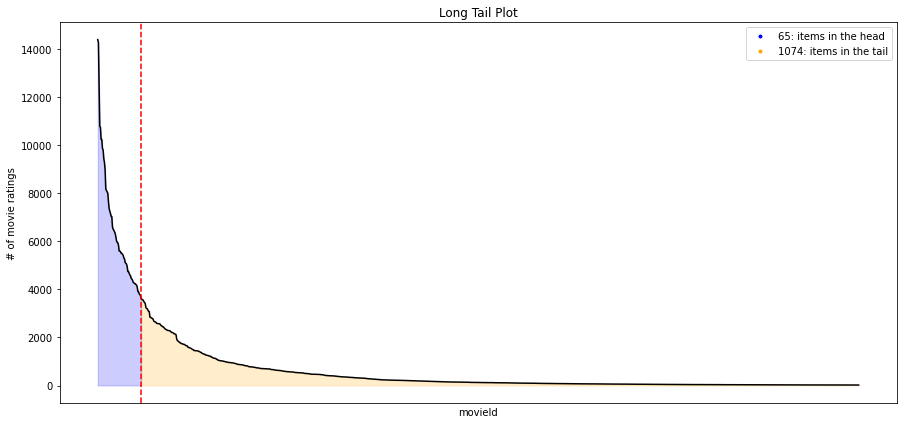

In [ ]:
fig = plt.figure(figsize=(15, 7))
long_tail_plot(df=larger_dataset, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

In [ ]:
movies = larger_dataset.copy()
movies.set_index("movieId", inplace=True, drop=True)
movies = movies.genres.str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4])
movies.drop_duplicates("movieId", inplace=True)
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
11,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
44,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
82,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
84,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
def string2float(string):
    try:
        output = float(string)
    except ValueError:
        output = None
    return output
# def float2int(float):
#     try:
#         output = int(float)
#     except ValueError:
#         output = None
#     return output

Below is the distribution of the movie released year. We can see from it that The number of movies has exploded after 2000 and the trend continues to 2020.

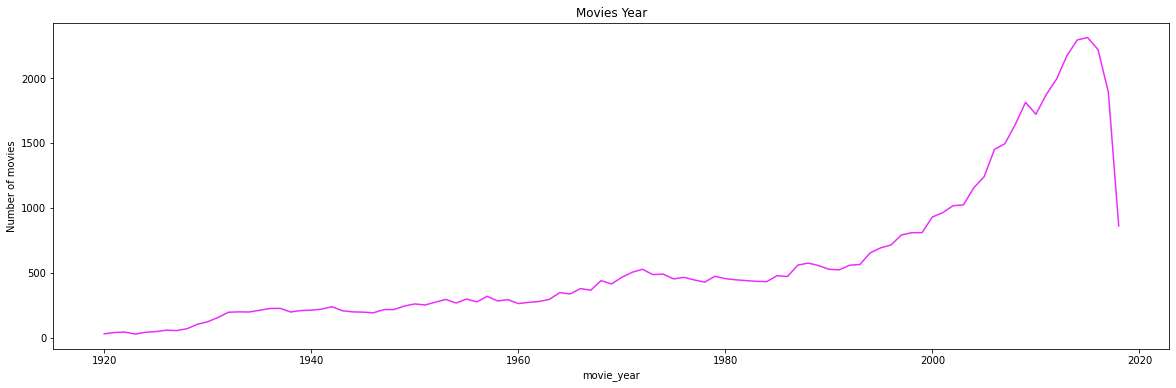

In [ ]:
# Distribution of the Movie Released Year
movie_year = full_movies.copy()
movie_year['movie_year'] = movie_year.title.map(lambda x:x[-5:-1]).map(lambda x:string2float(x))
movie_year = movie_year.groupby(['movie_year']).movieId.count()
plt.figure(figsize=(20,6))
recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
sns.set_palette(recommender_palette)
movie_year = movie_year[1920:]
ax = sns.lineplot(x=movie_year.index, y=movie_year.values)
ax.set_title("Movies Year")
ax.set_ylabel("Number of movies")
plt.show()

Below is the distribution of user's most-watched movie decade. We can see that users watched movie in 2000s most.

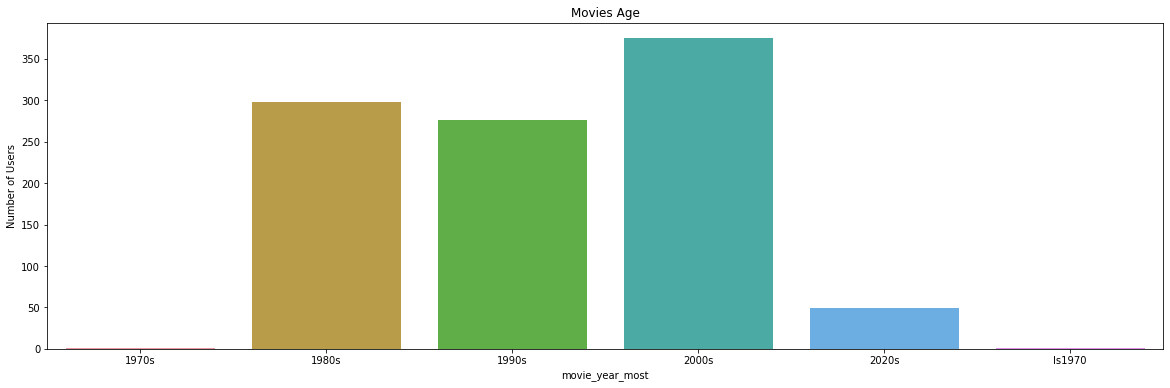

In [ ]:
# The distribution of user's most-watched movie decade.
movie_year = development_dataset.copy()
movie_year['movie_year_bucket'] = movie_year.title.map(lambda x:x[-5:-1]).astype(int).map(createUserProfile.year2bucket)
movie_year = movie_year.set_index('userId')
movie_year = pd.get_dummies(movie_year['movie_year_bucket'])
movie_year = movie_year.reset_index()
movie_year = movie_year.groupby('userId').sum()
movie_year = pd.DataFrame(movie_year.apply(lambda row: movie_year.columns[np.argmax(row.values)], axis=1)).rename(columns={0:'movie_year_most'})
movie_year = movie_year.reset_index().groupby(['movie_year_most']).count().userId
plt.figure(figsize=(20,6))
recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
sns.set_palette(recommender_palette)
ax = sns.barplot(x=movie_year.index, y=movie_year.values)
ax.set_title("Movies Age")
ax.set_ylabel("Number of Users")
plt.show()

# Baseline Model
Using hw2 two CF models as baseline models.

## Item-based Model

### Model Training and Evaluation

In [ ]:
class ItemCF:

    def __init__(self, train_org, dataset, k, n, only_popular=False):
        self.dataset = dataset
        self.k = k
        self.n = n
        self.train_org = train_org
        self.only_popular = only_popular

    def prepare_matrix(self):
        full_matrix = self.dataset.pivot(index='userId', columns='movieId', values='rating').to_numpy()
        self.full_matrix = full_matrix

    def build_train_test_split_itemCF(self):
        self.prepare_matrix()
        origin = self.dataset.pivot(index='userId', columns='movieId', values='rating')
        self.origin = origin
        origin = self.origin.replace(list(self.dataset['rating'].unique()),np.nan)
        for i in range(len(self.train_org)):
            origin.loc[self.train_org.iloc[i]['userId']][self.train_org.iloc[i]['movieId']] = self.train_org.iloc[i]['rating']
        self.train = origin.to_numpy()

    def centered_matrix(self):
        train_matrix = self.train
        user_mean = np.nanmean(train_matrix, axis = 1)
        centered_train = train_matrix - user_mean[:, np.newaxis]
        self.centered_train = centered_train

    def adjusted_cosine(self):
        centered_train = self.centered_train
        where_are_NaNs = np.isnan(centered_train)
        new_ = np.copy(centered_train)
        new_[where_are_NaNs] = 0
        squares = np.square(new_)
        inner_product = new_.T.dot(new_)
        new_2 = np.copy(centered_train)
        new_2[~np.isnan(new_2)] = 0
        new_2[np.isnan(new_2)] = 1
        new_2 = 1 - new_2
        temp_ = squares.T.dot(new_2)
        temp_inner_product = temp_.T * temp_
        temp_new = np.sqrt(temp_inner_product)
        adjusted_cosine = np.divide(inner_product,temp_new)
        self.adjusted_cosine = adjusted_cosine

    def KNearestNeighbor(self):
        adjusted_cosine = self.adjusted_cosine
        k = self.k
        temp_ = np.copy(adjusted_cosine)
        temp_[np.isnan(temp_)] = 0   
        ranking = np.argsort(-1 * temp_)[:,1:k+1]
        self.ranking = ranking

    def predict(self, user, item):
        train_matrix = self.train
        adjusted_cosine = self.adjusted_cosine
        ranking = self.ranking
        user_ratings_for_similar_items = train_matrix[user,ranking[item]]
        similarity_for_similar_items = adjusted_cosine[item,ranking[item]]
        value = np.dot(user_ratings_for_similar_items, similarity_for_similar_items)/sum(np.absolute(similarity_for_similar_items))
        if np.isnan(value):
            value = np.nanmean(train_matrix[user])
            value = round(value * 2) / 2
        if np.isnan(value):
            value = 3
        return value

    def user_item_pair(self):
        train_matrix = self.train
        index = list(np.argwhere(~np.isnan(train_matrix)))
        train_user_item_pair = {}
        for i in range(len(index)):
            if index[i][0] not in train_user_item_pair.keys():
                train_user_item_pair[index[i][0]]=[index[i][1]]
            else:
                train_user_item_pair[index[i][0]].append(index[i][1])
        self.train_user_item_pair = train_user_item_pair

    def recommend(self, user_idx):
        train_matrix = self.train
        train_user_item_pair = self.train_user_item_pair
        ranking = self.ranking
        adjusted_cosine = self.adjusted_cosine
        n = self.n
        try:
            watched_movies = train_user_item_pair[user_idx]
        except:
            watched_movies = []
        # watched_movies = train_user_item_pair[user_idx]
        recommendation={}
        for item_idx in watched_movies:
            nearest_item_idx = ranking[item_idx]
            for neighbor_item in nearest_item_idx:
                if neighbor_item in watched_movies:
                    continue
                if neighbor_item not in recommendation:
                    recommendation[neighbor_item] = adjusted_cosine[item_idx][neighbor_item]
                else:
                    if adjusted_cosine[item_idx][neighbor_item] >  recommendation[neighbor_item]:
                        recommendation[neighbor_item] = adjusted_cosine[item_idx][neighbor_item]
            break
        recommendation=sorted(recommendation.items(), key=lambda  x:x[1], reverse=True)
        return recommendation

    def RMSE(self):
        pred = self.pred
        act = self.act
        self.rmse = np.sqrt(sum(abs((np.array(pred)-np.array(act)))**2)/len(act))

    def build_itemCF(self, test_org):
        self.prepare_matrix()
        self.build_train_test_split_itemCF()
        self.user_item_pair()
        self.centered_matrix()
        self.adjusted_cosine()
        self.KNearestNeighbor()
        k = self.k
        n = self.n
        centered_train = self.centered_train
        adjcosine_train = self.adjusted_cosine
        ranking = self.ranking
        train_matrix = self.train
        self.test_org = test_org
        origin = self.origin.replace(list(self.dataset['rating'].unique()),np.nan)
        for i in range(len(self.test_org)):
            origin.loc[self.test_org.iloc[i]['userId']][self.test_org.iloc[i]['movieId']] = self.test_org.iloc[i]['rating']
        self.test = origin.to_numpy()
        self.test_idx = list(np.argwhere(~np.isnan(self.test)))
        test_idx = self.test_idx
        full_matrix = self.full_matrix
        prediction = []
        act = []
        ## when you run fine-tuning and impact of sample size, ignore the calculation of recommendation
        recommendation = {}
        for i in test_idx:
            prediction.append(self.predict( i[0], i[1] ))
            act.append(full_matrix[i[0],i[1]])
            recommendation[i[0]] = self.recommend(i[0])
        self.pred = prediction
        self.act = act
        self.rec = recommendation
    

    def getDCG(self, scores):
        return np.sum(
            np.divide(np.power(2, scores) - 1, np.log(np.arange(scores.shape[0], dtype=np.float32) + 2)),
            dtype=np.float32)


    def getNDCG(self, rank_list, pos_items):
        relevance = np.ones_like(pos_items)
        it2rel = {it: r for it, r in zip(pos_items, relevance)}
        rank_scores = np.asarray([it2rel.get(it, 0.0) for it in rank_list], dtype=np.float32)
        idcg = self.getDCG(np.sort(relevance)[::-1])
        dcg = self.getDCG(rank_scores)
        if dcg == 0.0:
            return 0.0
        ndcg = dcg / idcg
        return ndcg

    def precision(self):
        predicted = self.predicted
        pos_item = self.pos_item
        precision = []
        for i in range(len(pos_item)):
            reletive_and_retrieved = len(set(predicted[i]).intersection(set(pos_item[i])))
            retrieved = len(predicted[i])
            if retrieved == 0:
                precision.append(0)
            else:
                precision.append(reletive_and_retrieved/retrieved)
        self.prec = np.mean(np.array(precision))

    def prepare_for_ndcg(self):
        unpopularity = self.dataset.movieId.value_counts()<10
        unpopular = unpopularity[unpopularity==True]
        only_popular = self.only_popular
        test_idx = self.test_idx
        rec = self.rec
        origin = self.dataset.pivot(index='userId', columns='movieId', values='rating')
        predicted_new = [] 
        new_rec=[]
        for key,value in rec.items():
            list_=[]
            for item in value:
                list_.append(item[0])
            new_rec.append(list_)
        predicted = new_rec
        for i in predicted:
            new = []
            for item in i:
                add = origin.columns[item]
                if only_popular==True and add in unpopular:
                    continue
                else:
                    new.append(add)
            predicted_new.append(new)
        predicted = predicted_new
        test_user_item = {}
        for i in test_idx:
            if i[0] in test_user_item.keys():
                test_user_item[i[0]].append(origin.columns[i[1]])
            else:
                test_user_item[i[0]] = [origin.columns[i[1]]]
        pos_item = []
        for _,value in test_user_item.items():
            pos_item.append(value)
        self.predicted = predicted
        self.pos_item = pos_item
    
    def evaluate(self, test_org):
        ## rmse
        self.build_itemCF(test_org)
        full_matrix = self.full_matrix
        train_matrix, test_idx = self.train, self.test_idx
        pred, act, rank, rec = self.pred, self.act, self.ranking, self.rec
        self.RMSE()
        ## ndcg
        self.prepare_for_ndcg()
        predicted, pos_item = self.predicted, self.pos_item
        ndcg = []
        for i in range(len(pos_item)):
            ndcg.append(self.getNDCG(predicted[i],pos_item[i]))
        ndcg = np.mean(np.array(ndcg))
        self.ndcg = ndcg
        ## precision
        self.precision()
        return self.ndcg, self.prec
        return self.rmse

### Full Pipeline of ItemCF

In [ ]:
# full pipeline
# Hyper parameter
k = 50
n = 50
# dataset preparation
# train, test = build_train_test_split(larger_dataset)

# train, test = build_train_test_split(development_dataset)

# trainging and evaluation model
itemcf_model = ItemCF(train, full_dataset, 50, 50)
ndcg_itemcf, precisionTopK_itemcf = itemcf_model.evaluate(test)

print('precision at Top {} is {}'.format(k, precisionTopK_itemcf))
print('ndcg is {}'.format(ndcg_itemcf))

rec_list_itemcf, actual_list_itemcf = itemcf_model.predicted, itemcf_model.pos_item

precision at Top 50 is 0.0021944566748680404
ndcg is 0.007377953205922546


## Model-based Model

### Model Training

In [ ]:
class MatrixFactorization():
    # Prepare dataset, make them proper for spark ml, split the dataset
    @staticmethod
    def prepare_suitable_dataset(dataset, pct):
        dataset.userId = dataset.userId.astype('int')
        dataset.movieId = dataset.movieId.astype('int')
        dataset.rating = dataset.rating.astype('double')
        train, test = build_train_test_split(dataset)
        if pct < 1.0:
            train = sample_size(train, pct)
        ratings_train = spark.createDataFrame(train)
        ratings_test = spark.createDataFrame(test)
        return ratings_train, ratings_test, unpopular_list
        
    def train_MF(self):
        start = time.time()
        als = ALS(maxIter=self.maxIter, regParam=self.regParam, rank=self.rank, userCol="userId", itemCol="movieId", ratingCol="rating",coldStartStrategy='drop')
        self.model = als.fit(self.ratings_train)
        # end to count the execute time
        end = time.time()
        predictions = self.model.transform(self.ratings_test)

        evaluator = RegressionEvaluator(metricName=self.metricName, 
                                        labelCol="rating",
                                        predictionCol="prediction")
        self.metric = evaluator.evaluate(predictions)
        self.time = end-start
        self.users = self.ratings_test.select(als.getUserCol()).distinct()
    
    @staticmethod
    def getUnpopularList(ratings_train):
        data_counts = ratings_train.groupBy('movieId').count()
        movieid_df = data_counts[data_counts['count'] < 10].select('movieId')
        movieid_list = list(movieid_df.toPandas()['movieId'])
        return movieid_list
    
    @staticmethod
    def createDataFrame(data, pct=1.0):
        if pct < 1.0:
            data = sample_size(data, pct)
        ratings_data = spark.createDataFrame(data)
        return ratings_data




### Model Evaluation

In [ ]:
## Offline Ranking Evaluator
## modified based on https://vinta.ws/code/build-a-recommender-system-with-pyspark-implicit-als.html

class RankingEvaluator(Evaluator):

    @keyword_only
    def __init__(self, k=None, metricName=None,isTrain=False):
        super(RankingEvaluator, self).__init__()
        self.k = Param(self, 'k', 'Top K')
        self.metricName = Param(self, 'metricName', 'metricName')
        self.isTrain=isTrain
        self._setDefault(k=k, metricName=metricName)


    @keyword_only
    def setParams(self, k=None, metricName=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def isLargerBetter(self):
        return True

    def setK(self, value):
        self._paramMap[self.k] = value
        return self

    def getK(self):
        return self.getOrDefault(self.k)

    def setMetricName(self, value):
        self._paramMap[self.metricName] = value
        return self

    def getMetricName(self):
        return self.getOrDefault(self.metricName)

    def _evaluate(self, test, recommendationDF, train):

        k = self.getK()
        metricName = self.getMetricName()


        windowSpec = Window.partitionBy('userId').orderBy(F.col('rating').desc())

        perUserActualItemsDF = test \
            .select('userId', 'movieId', 'rating', F.rank().over(windowSpec).alias('rank')) \
            .groupBy('userId') \
            .agg(F.expr('collect_list(movieId) as items'))

        windowSpec = Window.partitionBy('userId').orderBy(F.col('rating').desc())
        exclude_watched_item = train.select('userId', 'movieId', 'rating', F.rank().over(windowSpec).alias('rank')) \
            .groupBy('userId') \
            .agg(F.expr('collect_list(movieId) as items'))
        recommendationDF = recommendationDF.join(F.broadcast(exclude_watched_item), 'userId', 'inner')
        
        perUserItemsRDD = recommendationDF.join(F.broadcast(perUserActualItemsDF), 'userId', 'inner')
        
        def _k_list(row):
          # only recommend items user has not wateched 
            rec_list=[item for item in row[1] if item not in set(row[2])][:k]
            return (rec_list,row[3])    
       
        perUserItemsRDD=perUserItemsRDD.rdd \
            .map(lambda row: _k_list(row))
       
        if perUserItemsRDD.isEmpty():
            return 0.0

        rankingMetrics = RankingMetrics(perUserItemsRDD)
        if self.isTrain:
            if metricName == 'ndcg':
                metric_ndcg = rankingMetrics.ndcgAt(k)
                return metric_ndcg
          
            if metricName == 'precisionTopk':
                metric_precisionTopk = rankingMetrics.precisionAt(k)
                return metric_precisionTopk
        else:
            metric_ndcg = rankingMetrics.ndcgAt(k)
            metric_precisionTopk = rankingMetrics.precisionAt(k)
            return metric_ndcg, metric_precisionTopk
        return ValueError('Metric {} not found'.format(metricName))


###  Full pipeline of MF

In [ ]:
# full pipeline
# Hyper parameter
pct = 1.0
k = 50

# dataset preparation
ratings_train = MatrixFactorization.createDataFrame(train, pct=pct)
ratings_test = MatrixFactorization.createDataFrame(test)
unpopular_list = MatrixFactorization.getUnpopularList(ratings_train)


# train ALS model
als_setup = ALS(maxIter=10, rank=100, regParam=0.1,userCol="userId", itemCol="movieId", ratingCol="rating",coldStartStrategy='drop')
als_model = als_setup.fit(ratings_train)
prediction_df = als_model.transform(ratings_test)
recommendation_df = als_model.recommendForUserSubset(prediction_df.select("userId").distinct(), 100 ).select('userId', 'recommendations.movieId')

# get metrics for the model
rankingEvaluator = RankingEvaluator(k=k)
ndcg_MF, precisionTopK_MF = rankingEvaluator._evaluate(prediction_df, recommendation_df, ratings_train)

regressionEvaluator = RegressionEvaluator(metricName="rmse", 
                                        labelCol="rating",
                                        predictionCol="prediction")
rmse_MF = regressionEvaluator.evaluate(prediction_df.na.drop())

print('precision at Top {} is {}'.format(k, precisionTopK_MF))
print('ndcg is {}'.format(ndcg_MF))

precision at Top 50 is 0.016225585693591088
ndcg is 0.07527816171477562


In [ ]:
def final_recommendation(ratings_test,recommendationDF,k=50):
    windowSpec = Window.partitionBy('userId').orderBy(col('rating').desc())
    exclude_watched_item = ratings_train.select('userId', 'movieId', 'rating', F.rank().over(windowSpec).alias('rank')) \
            .groupBy('userId') \
            .agg(expr('collect_list(movieId) as items'))
    recommendationDF = recommendationDF.join(F.broadcast(exclude_watched_item), 'userId', 'inner')
    perUserActualItemsDF=ratings_test \
            .select('userId', 'movieId') \
            .groupBy('userId') \
            .agg(expr('collect_list(movieId) as actual_items'))
    
    recommendationDF=recommendationDF.join(F.broadcast(perUserActualItemsDF), 'userId', 'inner')
    actual_list=recommendationDF.select('actual_items').toPandas().values
    def _k_list(row):
      # only recommend items user has not wateched 
        rec_list=[item for item in row[1] if item not in set(row[2])][:k]
        return rec_list   
    
    recommendationDF=recommendationDF.rdd \
            .map(lambda row: _k_list(row)) 
    
    return recommendationDF.collect(), [l[0] for l in actual_list]
    

In [ ]:
rec_list_MF, actual_list_MF = final_recommendation(prediction_df,recommendation_df)

# The detailed building and Analysis of each model in new hybrid system

## User Feature Engineering
Based on information from training data frame ratings, tags and genres, we build user profiles. 
These features could be useful to extract user’s preferences and bais on rating. Some users preferred to rate high and some may prefer rate lower, however maybe both of them feel good toward this movie. 
Also we try to dig some demographic information of users based on information we had. For example, with the help of timestamp, we could know the participation age of users and participation duration of users.

Features are:

* rating_count: this measures how many movies this user has rated.
* recent_title: the recent movie user rated.
* recent_rating_tag: the recent rated movie’s tag.
* movie_age_most : for each user, which year bucket most of rated movies are in.
* rating_mean: the mean of rating for each user. 
* rating_std: the standard deviation of rating for each user.
* rating_min: the minimum rating for each user.
* rating_max: the maximum rating for each user.
* rating_genre_most: users rated which genres most. 
* most_rating_tag: users rated which tags most. 
* tag_per_user: number of tags per user.
* participate_age: when the user began to rate movies.
* participate_last: when is the user’s recent rating.
* movie_year_mean,movie_year_std,movie_year_min,movie_year_max: statistical information about the year of  movies were rated for a user.
* 1970s, 1980s, 1990s,2000s,2020s, ls1970:  number of rated movies for a user, based on released year.
* genre_Action, genre_Adventure, genre_Animation, genre_Children, genre_Comedy, genre_Crime, genre_Documentary, genre_Drama,genre_Fantasy, genre_Horror, genre_Thriller : the number of movies in each genre. 

We also created some cross categorical features as well. 


In [ ]:
class createUserProfile():

    def __init__(self, dataset):
        self.dataset = dataset

    def combine(self):
        rating_count_df = self.rating_count()
        rating_score_df = self.rating_score()
        rating_genre_most_df = self.rating_genre_most()
        participate_df = self.participation()

        # user打分过的电影上映时间stat数据（max\min\avg\std）
        movie_year_stat_df = self.movie_year_stat()
        # user最近打分过的电影（电影名）
        movie_year_recent_df = self.movie_year_recent()
        # user最近打过的tag（tag名字）
        recent_tag_df = self.recent_tag()
        # user打过最多的tag（tag名字）
        most_rate_tag_df = self.most_rate_tag()
        # user打分过的电影年代分布（ls1970,1970s,1980s,1990s,2000s,2010s)
        movie_year_buckets_df = self.movie_year_buckets()
        # user打分过的电影题材计数（action等）
        genre_buckets_df = self.genre_buckets()
        return rating_count_df.join(rating_score_df).join(rating_genre_most_df).join(participate_df).join(movie_year_stat_df).join(movie_year_recent_df).join(recent_tag_df).join(most_rate_tag_df).join(movie_year_buckets_df).join(genre_buckets_df)

    def rating_count(self):
        rating_count_df = pd.DataFrame(self.dataset.groupby('userId').rating.count()).rename(columns={'rating': 'rating_count'})
        return rating_count_df

    def rating_score(self):
        rating_mean_df = pd.DataFrame(self.dataset.groupby('userId').rating.mean()).rename(columns={'rating': 'rating_mean'})
        rating_variance_df = pd.DataFrame(self.dataset.groupby('userId').rating.std()).rename(columns={'rating': 'rating_std'})
        rating_min_df = pd.DataFrame(self.dataset.groupby('userId').rating.min()).rename(columns={'rating': 'rating_min'})
        rating_max_df = pd.DataFrame(self.dataset.groupby('userId').rating.max()).rename(columns={'rating': 'rating_max'})
        return rating_mean_df.join(rating_variance_df).join(rating_min_df).join(rating_max_df)

    def rating_genre_most(self):
        movies = self.dataset.copy()
        movies.set_index("movieId", inplace=True, drop=True)
        movies = movies.genres.str.split("|", expand=True)
        movies.reset_index(inplace=True)
        movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4])
        movies.drop_duplicates("movieId", inplace=True)
        movies.set_index('movieId', inplace=True)
        movies = pd.get_dummies(movies.value)
        try:
            movies = movies.drop('(no genres listed)', axis=1)
        except:
            pass
        development_dataset = self.dataset.drop(['genres'], axis=1)

        def sort_values_return_name(row):
            return movies.columns[np.argmax(row.values)]
        rating_genre_most_df = development_dataset.merge(movies, left_on='movieId', right_on='movieId')
        rating_genre_most_df = rating_genre_most_df.groupby('userId')[movies.columns].sum()
        rating_genre_most_df = pd.DataFrame(rating_genre_most_df.apply(lambda row: sort_values_return_name(row), axis=1)).rename(columns={0: 'rating_genre_most'})
        return rating_genre_most_df

    def participation(self):
        participate_age = pd.DataFrame(self.dataset.groupby('userId').apply(lambda row: pd.to_datetime(row.timestamp.min(), unit='s'))).rename(columns={0: 'participate_age'})
        participate_age.participate_age = participate_age.participate_age.dt.year
        participate_age.participate_age = 2020-participate_age.participate_age

        participate_last = pd.DataFrame(self.dataset.groupby('userId').apply(lambda row: pd.to_datetime(row.timestamp.max(), unit='s'))).rename(columns={0: 'participate_last'})
        participate_last.participate_last = participate_last.participate_last.dt.year
        participate_last.participate_last = 2020-participate_last.participate_last
        return participate_age.join(participate_last)

    ## ------菜鸡补充的分割线------

    def movie_year_stat(self):
        movie_year = self.dataset.copy()
        
        p1 = re.compile(r'[(](\d+)[)]', re.S)
        movie_year['movie_year'] = movie_year.title.map(lambda x: re.findall(p1, x)[0] if re.findall(p1, x) else 0).astype(int)
        movie_year_mean_df = pd.DataFrame(movie_year.groupby('userId').movie_year.mean()).rename(columns={'movie_year': 'movie_year_mean'})
        movie_year_variance_df = pd.DataFrame(movie_year.groupby('userId').movie_year.std()).rename(columns={'movie_year': 'movie_year_std'})
        movie_year_min_df = pd.DataFrame(movie_year.groupby('userId').movie_year.min()).rename(columns={'movie_year': 'movie_year_min'})
        movie_year_max_df = pd.DataFrame(movie_year.groupby('userId').movie_year.max()).rename(columns={'movie_year': 'movie_year_max'})
        return movie_year_mean_df.join(movie_year_variance_df).join(movie_year_min_df).join(movie_year_max_df)

    def movie_year_recent(self):
        movie_year = self.dataset.copy()
        p1 = re.compile(r'[(](\d+)[)]', re.S)
        movie_year['movie_year'] = movie_year.title.map(lambda x: re.findall(p1, x)[0] if re.findall(p1, x) else 0 ).astype(int)
        movie_year['rn'] = movie_year.groupby(['userId']).movie_year.rank(ascending=0,method='first').astype(int)
        movie_year = movie_year[movie_year['rn'] == 1].set_index(['userId'])[['title']].rename(columns={'title':'recent_title'})
        return movie_year
        
    def recent_tag(self):
        recent_tag = full_tags.copy()
        recent_tag['rn'] = recent_tag.groupby(['userId']).timestamp.rank(ascending=0,method='first').astype(int)
        recent_tag = recent_tag[recent_tag['rn'] == 1].set_index(['userId']).rename(columns={'tag':'recent_rating_tag'})
        return recent_tag['recent_rating_tag']
    
    def most_rate_tag(self):
        max_tag = full_tags.copy()
        max_tag['count'] = max_tag.groupby(['userId','tag']).tag.transform('count')
        max_tag['rn'] = max_tag.groupby(['userId'])[['count']].rank(ascending=0,method='first')
        max_tag = max_tag[max_tag['rn'] == 1].set_index(['userId']).rename(columns={'tag':'most_rating_tag'})
        return max_tag['most_rating_tag']

    @staticmethod
    def year2bucket(year):
        """convert movie year into feature buckets"""
        if year < 1970:
            return 'ls1970'
        elif year < 1980:
            return '1970s'
        elif year < 1980:
            return '1970s'
        elif year < 1990:
            return '1980s'
        elif year < 2000:
            return '1990s'
        elif year < 2010:
            return '2000s'
        else:
            return '2020s'
                   
    def movie_year_buckets(self):
        movie_year = self.dataset.copy()
        p1 = re.compile(r'[(](\d+)[)]', re.S)
        movie_year['movie_year_bucket'] = movie_year.title.map(lambda x: re.findall(p1, x)[0] if re.findall(p1, x) else 0 ).astype(int).map(self.year2bucket)
        movie_year = movie_year.set_index('userId')
        movie_year = pd.get_dummies(movie_year['movie_year_bucket'])
        movie_year = movie_year.reset_index()
        movie_year = movie_year.groupby('userId').sum()
        movie_year['movie_age_most'] = pd.DataFrame(movie_year.apply(lambda row: movie_year.columns[np.argmax(row.values)], axis=1))
        return movie_year

    def genre_buckets(self):
        """采用genre_raing_most的逻辑"""
        movies = self.dataset.copy()
        movies.set_index("movieId", inplace=True, drop=True)
        movies = movies.genres.str.split("|", expand=True)
        movies.reset_index(inplace=True)
        movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4])
        movies.drop_duplicates("movieId", inplace=True)
        movies.set_index('movieId', inplace=True)
        movies = pd.get_dummies(movies.value)
        try:
            movies = movies.drop('(no genres listed)', axis=1)
        except:
            pass
        test_set = self.dataset.drop(['genres'], axis=1)
        def sort_values_return_name(row):
            return movies.columns[np.argmax(row.values)]
        rating_genre_most_df = test_set.merge(movies, left_on='movieId', right_on='movieId')
        rating_genre_most_df = rating_genre_most_df.groupby('userId')[movies.columns].sum()
#         该函数与genre_raing_most直到这里都是相同的
        return rating_genre_most_df.rename(columns={x:'genre_'+x for x in movies.columns})

In [ ]:
createUserProfile(development_dataset).combine()

,rating_count,rating_mean,rating_std,rating_min,rating_max,rating_genre_most,participate_age,participate_last,movie_year_mean,movie_year_std,...,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Thriller
userId,,,,,,,,,,,,,,,,,,,,,
408.0,12,3.000000,0.738549,2.0,4.0,Drama,21,21,1985.166667,13.148338,...,3,0,0,8,0,0,0,0,0,0
491.0,14,3.571429,1.016350,2.0,5.0,Comedy,20,20,1995.142857,4.521013,...,9,1,0,2,0,0,0,0,0,0
526.0,14,3.214286,1.204388,0.5,5.0,Drama,5,5,1997.857143,11.468064,...,1,1,1,5,1,1,0,0,0,0
549.0,19,4.315789,0.820070,2.0,5.0,Drama,11,11,1989.105263,14.869412,...,3,2,0,7,0,0,0,0,0,0
605.0,23,2.565217,1.576131,0.5,4.5,Action,9,7,1995.347826,11.523134,...,4,1,0,5,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281631.0,37,3.189189,0.690726,1.5,5.0,Drama,11,11,1989.351351,19.090743,...,6,2,0,15,0,2,0,0,0,1
282119.0,16,2.906250,1.098768,0.5,5.0,Action,14,3,1990.250000,26.210685,...,4,1,0,2,0,0,0,0,1,0
282203.0,18,3.555556,0.661747,2.5,5.0,Drama,5,2,1996.055556,21.571965,...,1,0,0,8,1,0,0,0,0,0


## Movie Feature Engineering

Except for features for the user side, features for the movie side are also needed for our models to build interaction and feature matrices. This part of the features are more for movie information like to define the tags per movie, genres per movie. Moreover, these features are more like features prepared for a content based model.


Movie features are:
* tag_per_movie: number of tags per movie
* genre_per_movie: number of genres per movie
* tagId: highest relevant tag per movie
* rating_per_movie: number of ratings per movie
* highest_rating: highest rating per movie
* lowest_rating: lowest rating per movie
* rated_last: (last time being rated) (need to bin values)
* rated_first: (first time being rated) (need to bin values)
* rating_mean: mean rating per movie
* rating_std: std_dev of rating per movie
* rating_duration: rating duration per movie


In [ ]:
class createProfile(object): 
    def __init__(self, dataset, full_tags, full_genome_scores):
        self.full_tags = full_tags
        self.full_genome_scores = full_genome_scores
        self.dataset = dataset
        self.user()
        self.movie()
        
    ## bin values into 20 buckets
    def bin_values(self, x):
        x = x.astype(float)
        bin = list(np.arange(20+1)*(1/20))
        bin = x.quantile(bin)
        bin[0] = bin[0]-0.01
        return pd.cut(x, bin)

    def user(self):
        self.user_feature = self.full_tags.userId.value_counts().to_frame().rename(columns={'userId':'tag_per_user'})
        new = pd.Series(self.dataset.userId.unique()).to_frame().rename(columns={0:'userId'})
        idx = self.user_feature.index.rename('userId')
        self.user_feature.index = idx
        self.user_feature = pd.merge(self.user_feature, new, how='right', left_index=True, right_on='userId').fillna(0).set_index('userId')


    def movie(self):
        self.tag_per_movie = self.full_tags.movieId.value_counts().to_frame().rename(columns={'movieId':'tag_per_movie'})
        idx = self.tag_per_movie.index.rename('movieId')
        self.tag_per_movie.index = idx

        new = self.dataset[['movieId','genres']].drop_duplicates(subset=None, keep='first', inplace=False).set_index('movieId')
        new = new.genres.apply(lambda x: len(x.split("|")))
        self.genre_per_movie = new.to_frame().rename(columns={'genres':'genre_per_movie'})

        max_ = self.full_genome_scores.sort_values(['movieId','relevance']).drop_duplicates(['movieId'], keep='last').set_index('movieId')
        self.highest_relevant_tag = max_["tagId"].to_frame()

        self.rating_per_movie = self.dataset.groupby('movieId').rating.count().to_frame().rename(columns={'rating':'rating_per_movie'})

        self.highest_rating = self.dataset.groupby('movieId').rating.max().to_frame().rename(columns={'rating':'highest_rating'})

        self.lowest_rating = self.dataset.groupby('movieId').rating.min().to_frame().rename(columns={'rating':'lowest_rating'})

        self.rated_last = self.bin_values(self.dataset.groupby('movieId').timestamp.max()).to_frame().rename(columns={'timestamp':'rated_last'})

        self.rated_first = self.bin_values(self.dataset.groupby('movieId').timestamp.min()).to_frame().rename(columns={'timestamp':'rated_first'})

        self.rating_mean = self.dataset.groupby('movieId').rating.mean().to_frame().rename(columns={'rating':'rating_mean'})

        self.rating_std = self.dataset.groupby('movieId').rating.std().to_frame().rename(columns={'rating':'rating_std'})

        self.rating_duration = self.bin_values(self.dataset.groupby('movieId').timestamp.max()-self.dataset.groupby('movieId').timestamp.min()).to_frame().rename(columns={'timestamp':'rating_duration'})

        self.movie_feature = pd.merge(self.tag_per_movie, self.genre_per_movie, how='right', left_index=True, right_index=True).fillna(0)
        self.movie_feature = pd.merge(self.movie_feature, self.highest_relevant_tag, how='left', left_index=True, right_index=True).fillna(0)
        self.movie_feature = pd.merge(self.movie_feature, self.rating_per_movie, how='inner', left_index=True, right_index=True)
        self.movie_feature = pd.merge(self.movie_feature, self.highest_rating, how='inner', left_index=True, right_index=True)
        self.movie_feature = pd.merge(self.movie_feature, self.lowest_rating, how='inner', left_index=True, right_index=True)
        self.movie_feature = pd.merge(self.movie_feature, self.rating_mean, how='inner', left_index=True, right_index=True)
        self.movie_feature = pd.merge(self.movie_feature, self.rating_std, how='inner', left_index=True, right_index=True)        
        self.movie_feature = pd.merge(self.movie_feature, self.rated_last, how='inner', left_index=True, right_index=True)
        self.movie_feature = pd.merge(self.movie_feature, self.rated_first, how='inner', left_index=True, right_index=True)
        self.movie_feature = pd.merge(self.movie_feature, self.rating_duration, how='inner', left_index=True, right_index=True)

In [ ]:
## deal with movie cold-start problem
## for all the movie features, only number of tags per movie, number of generes per movie, and highest relevent tag per movie will have values

class movie_coldstart(object):
    def __init__(self, full, train, full_tags, full_genome_scores, if_develop=False):
        self.full = full
        self.train = train
        self.full_tags = full_tags
        self.full_genome_scores = full_genome_scores
        a = createProfile(self.train, full_tags, full_genome_scores)
        self.movie_feature = a.movie_feature
        self.user_feature = a.user_feature
        feature_df = createUserProfile(self.train).combine()
        # add user features in user_profile
        self.user_feature = pd.merge(self.user_feature, feature_df, how='inner', left_index=True, right_index=True).fillna(0)
    
    
    def ifexist(self):
        all_movie = set(self.full.movieId.unique())
        train_movie = set(self.train.movieId.unique())
        missing_movie = list(all_movie - train_movie)
        self.missing_movie = missing_movie
        self.not_exist_coldstart = len(missing_movie)==0
        self.no_missingmovie = len(missing_movie)

    def form(self):
        self.ifexist()
        if self.not_exist_coldstart==False:
            tag_per_movie = self.full_tags.movieId.value_counts().to_frame().rename(columns={'movieId':'tag_per_movie'})
            idx = tag_per_movie.index.rename('movieId')
            tag_per_movie.index = idx

            new = self.full[['movieId','genres']].drop_duplicates(subset=None, keep='first', inplace=False).set_index('movieId')
            new = new.genres.apply(lambda x: len(x.split("|")))
            genre_per_movie = new.to_frame().rename(columns={'genres':'genre_per_movie'})

            max = self.full_genome_scores.sort_values(['movieId','relevance']).drop_duplicates(['movieId'], keep='last').set_index('movieId')
            highest_relevant_tag = max["tagId"].to_frame()

            new_feature = pd.merge(tag_per_movie, genre_per_movie, how='right', left_index=True, right_index=True).fillna(0)
            new_feature = pd.merge(new_feature, highest_relevant_tag, how='left', left_index=True, right_index=True).fillna(0)

            nan_value = [np.nan] * 8 ## 8 columns of movie features will be np.nan
            new = pd.DataFrame()
            values = []
            for i in self.missing_movie:
                value = [i]
                try:
                    value.append(tag_per_movie.loc[i].values[0])
                except:
                    value.append(np.nan)
                try:
                    value.append(genre_per_movie.loc[i].values[0])
                except:
                    value.append(np.nan)
                try:
                    value.append(highest_relevant_tag.loc[i].values[0])
                except:
                    value.append(np.nan)
                value.extend(nan_value)
                values.append(value)

            col = ['movieId']
            col.extend(list(self.movie_feature.columns.values))

            missing = pd.DataFrame(values,columns=col).set_index('movieId')
            self.movie_feature = pd.concat([self.movie_feature, missing])

## LightFM Model

For this part, we use LightFM as our basic recommendation model.  LightFM is a hybrid matrix factorisation model representing users and items as linear combinations of their content features’ latent factors. The model outperforms both collaborative and content-based models in cold-start or sparse interaction data scenarios (using both user and item data), and performs at least as well as a pure collaborative matrix factorisation model where interaction data is abundant.

In LightFM, like in a collaborative filtering model, users and items are represented as latent vectors (embeddings). However,these are entirely defined by functions of embeddings of the content features that describe each movie or user.

### Model Buiding

At the beginning of the model building process, we have to deal with the movie cold-start problem. For all the movie features, only the number of tags per movie, number of genres per movie, and highest relevant tag per movie will have values according to our setting in advance.
Thus, after finding out the difference between the feature list gained from the training set and the full data set, we will get a list of missing movies because of the cold-start problem. After adding these values to the missing movies and concat them to the original feature list gained from the training set, we are ready to work on building the model. 

Firstly, we will transform our training and testing set to coo matrix format before putting them into our model. At the same time, we also need to prepare our feature list and feature data frame for both movie features and user features. 


In [ ]:
def coo_matrix_transform(full, train_org, test_org, if_develop=False):
    origin = full.pivot(index='userId', columns='movieId', values='rating')
    test = origin.copy()
    train_idx = train_org[['userId','movieId']].to_numpy()
    for i in range(len(train_idx)):
        test.loc[train_idx[i][0]][train_idx[i][1]] = np.nan
    train = origin.copy()
    test_idx = test_org[['userId','movieId']].to_numpy()
    for i in range(len(test_idx)):
        train.loc[test_idx[i][0]][test_idx[i][1]] = np.nan
    train = train.fillna(0)
    test = test.fillna(0)
    return csr_matrix(train.values).tocoo(copy=True),csr_matrix(test.values).tocoo(copy=True)

def generate_feature_list(dataframe, features_name):
    uf = []
    col = []
    unique = []
    for i in features_name:
        col += [i]*len(dataframe[i].unique())
        unique += list(dataframe[i].unique())
    for x,y in zip(col, unique):
        res = str(x)+ ":" +str(y)
        uf.append(res)
    return uf

def create_features(dataframe, features_name):
    uf = []
    for j in range(len(dataframe)):
        col = []
        for i in features_name:
            col += [str(i)+":"+str(dataframe[i].iloc[j])]
        uf.append((dataframe.index[j],col))
    return uf

The next step is for our model set up. Apart from the training dataset, testing dataset, full dataset, features from the sides of the user and movie, we also need to put no_components, the dimensionality of the feature latent embeddings, into our consideration as a hyperparameter. When we train our model, we choose fit_partial rather than fit. In this way, repeated calls to this method will cause training to resume from the current model state and thus we can add new users as well as new features during training. After training to return our fitted model, the fitted model will produce the user embeddings and feature embeddings for future use in the Wide and Deep model. 

The Evaluation will be based on AUC score and precision @ k which will be returned by our fitted LightFM model directly. 


In [ ]:
class lightFM(object):
    def __init__(self, train, train_org, full_tags, full_genome_scores, dataset, dimension, only_popular=False, if_develop=False):
        self.if_develop = if_develop
        a = movie_coldstart(dataset, train_org, full_tags, full_genome_scores, if_develop=self.if_develop)
        a.form()
        self.user_feature = a.user_feature
        self.movie_feature = a.movie_feature
        self.user_feature_list = generate_feature_list(self.user_feature,list(self.user_feature.columns))
        self.movie_feature_list = generate_feature_list(self.movie_feature,list(self.movie_feature.columns))
        self.df_movie = create_features(self.movie_feature, list(self.movie_feature.columns))
        self.df_user = create_features(self.user_feature, list(self.user_feature.columns))
        self.dataset = dataset
        self.only_popular = only_popular
        self.train = train
        self.train_org = train_org
        self.origin = self.dataset.pivot(index='userId', columns='movieId', values='rating')
        self.dimension = dimension

    def model_setup(self):
        dataset = Dataset()
        dataset.fit(
            set(self.user_feature.index), 
            set(self.movie_feature.index),
            item_features=self.movie_feature_list, 
            user_features=self.user_feature_list)
        self.movie = dataset.build_item_features(self.df_movie)
        self.user = dataset.build_user_features(self.df_user)
        model = LightFM(no_components=self.dimension, loss='warp')
        model.fit_partial(self.train, user_features=self.user, item_features=self.movie, epochs=30, num_threads=4)
        self.model = model
        self.user_embedding = self.model.user_embeddings 
        self.movie_embedding = self.model.item_embeddings 

    def eval(self, test, k):
        self.model_setup()
        self.test = test
        self.train_auc = auc_score(self.model, self.train, item_features=self.movie, user_features = self.user, num_threads=4).mean()
        self.test_auc = auc_score(self.model, self.test, item_features=self.movie, user_features = self.user, num_threads=4).mean()
        self.train_prec = precision_at_k(self.model, self.train, item_features=self.movie, user_features = self.user, num_threads=4, k=k).mean()
        self.test_prec = precision_at_k(self.model, self.test, item_features=self.movie, user_features = self.user, num_threads=4, k=k).mean()
        # print('Precision@%s: train %.2f, test %.2f.' % (k, self.train_prec, self.test_prec))
        # print('AUC: train %.2f, test %.2f.' % (self.train_auc, self.test_auc))
        return self.test_auc, self.test_prec

### Full pipeline

In [ ]:
# # use full_dataset to represent input data, no need to change between development dataset and full dataset
full_dataset = pd.concat([train, test])

train_coo, test_coo = coo_matrix_transform(full_dataset, train, test, if_develop=False)

dimension = 150
lightfm_model = lightFM(train_coo, train, full_tags, full_genome_scores, full_dataset, dimension, only_popular=False, if_develop=False)
lightfm_model.model_setup()

k = 50
metrics = lightfm_model.eval(test_coo, k)

### Cross Validation

Here we use the StratifiedKFold Cross Validation to find out our best hyperparameter  of LightFM model with our current dataset with the ranking metric precision@50 as priority.


Fine Tuning -- no_components d

The hyperparameter no_components d of lightFM model means the dimension of feature embeddings.

In [ ]:
def cross_val_lightfm(dataset, d, k, if_develop=True):
    auc = []
    prec = []
    for (train_org, test_org) in kfold(dataset):
        train, test = coo_matrix_transform(dataset, train_org, test_org, if_develop=if_develop)

        dimension = d
        lightfm_model = lightFM(train, train_org, full_tags, full_genome_scores, dataset, dimension, only_popular=False, if_develop=if_develop)

        metrics = lightfm_model.eval(test, k)
        auc.append(metrics[0])
        prec.append(metrics[1])

    return np.mean(auc), np.mean(prec)

In [ ]:
k = 50
dims = [50,100,150,200]
auc = []
prec = []
for d in dims:
    a, p = cross_val_lightfm(development_dataset, d, k, if_develop=True)
    auc.append(a)
    prec.append(p)

best d for auc: 150


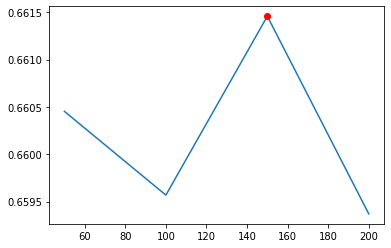

In [ ]:
print("best d for auc:",dims[np.argmax(auc)])
plt.plot(dims,auc)
plt.plot(dims[np.argmax(auc)],np.max(auc),'ro')
plt.show()

best d for prec: 100


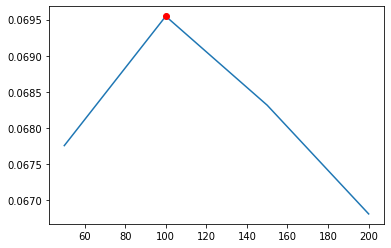

In [ ]:
print("best d for prec:",dims[np.argmax(prec)])
plt.plot(dims,prec)
plt.plot(dims[np.argmax(prec)],np.max(prec),'ro')
plt.show()

Considering ranking metric precision@50 as priority, we choose no_components=150 as the best parameter.

In [ ]:
k = 50
dims = [50,100,150,200]
auc = []
prec = []
for d in dims:
    a, p = cross_val_lightfm(development_dataset, d, k, if_develop=True)
    auc.append(a)
    prec.append(p)

## Ann
In order to set up an efficient system, we build ANN between retrieval models and reorder models. Approximate nearest neighbor is a fast and memory saving way to find movie candidates for a uses, so the online searching will be fast, and so the Wide & Deep model could respond more efficiently. 

With embedding vectors LightFM provided, we use Bucket Random Projection LSH to find candidates set for each user because it could accept dense vectors as input. 

Bucketed Random Projection is an LSH family for Euclidean distance. Its LSH family projects feature vectors x onto a random unit vector v and portions the projected results into hash buckets

where r is a user-defined bucket length. The bucket length can be used to control the average size of hash buckets (and thus the number of buckets). A larger bucket length (i.e., fewer buckets) increases the probability of features being hashed to the same bucket (increasing the numbers of true and false positives).



In [ ]:
# dataset preparation
ratings_train = MatrixFactorization.createDataFrame(train, pct=1)
ratings_test = MatrixFactorization.createDataFrame(test)

We should first transform the embedding data frame for users and movies as spark dataframe and appropriate data format, ID as int type and vectors as DenseVector. 

The parameters for Bucketed Random Projection are bucket length and number of hash tables. These two parameters are carefully chosen in order to make sure we could get a reasonable number of candidates for each user. 

Unlike usual hashing, we want to encourage collision in each bucket. The longer the bucket length, the smaller the number of buckets where the number of buckets equal to max( ||x||^2) // length of bucket, hence increasing the number of items in each bucket. 

According to the formula, max( ||x||^2) in users’ embedding space is around 26, so setting the  length of the bucket equal to 2 will give 13 buckets for each hash table. Ideally,  on average each bucket will have 1500 items. And in order to decrease the false negative and make it more robust, we set the hash table number equal to 5. 


In [ ]:
# using embedding from lightfm
user_embedding = []
for i in range(len(lightfm_model.origin)):
    user_embedding.append([item.astype('double') for item in lightfm_model.user_embedding[i]])
userembed_lightfm = pd.DataFrame(zip(pd.Series(lightfm_model.origin.index),pd.Series(user_embedding)),columns=["userId","features"])


movie_embedding = []
for i in range(lightfm_model.origin.shape[1]):
    movie_embedding.append([item.astype('double') for item in lightfm_model.movie_embedding[i]])
movieembed_lightfm = pd.DataFrame(zip(pd.Series(lightfm_model.origin.columns),pd.Series(movie_embedding)),columns=["movieId","features"])


user_latent = spark.createDataFrame(
    [(int(tup[0]), Vectors.dense([float(item) for item in tup[1]])) for tup in userembed_lightfm.values], 
    ["userId", "features"]
)
movie_latent = spark.createDataFrame(
    [(int(tup[0]), Vectors.dense([float(item) for item in tup[1]])) for tup in movieembed_lightfm.values], 
    ["movieId", "features"]
)

In [ ]:
brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes", bucketLength=2.0,
                                  numHashTables=5)
model = brp.fit(user_latent)

After training, we could easily find 100 candidates for each user by ANN search or find nearest candidates for batch users. These user-movie id pairs (and their embedding vectors) will become major components of  input for wide & deep models in online recommendation. 
Usually we will predict for batch users, the way to quickly find candidates for batch users is to utilize Approximate similarity join. It takes two datasets and approximately returns pairs of rows in the datasets whose distance is smaller than a user-defined threshold.  As we want to make sure each user has at least over 100 candidates for the next model to reorder, setting similarity threshold is 5 for Euclidean distance could make sure the minimum candidates number is over 100 (139 in in our experiment). If with higher computer power, we could increase this nubmer accordingly, which will make candidates set larger. 

Now without reordering, the ndcg and precision @ k is low.


In [ ]:
# quick evaluation of ann
windowSpec = Window.partitionBy("datasetA.userId").orderBy(col('distCol').desc())
recommenddf=model.approxSimilarityJoin(user_latent, movie_latent, 5, distCol="distCol")\
    .select(col("datasetA.userId").alias("userId"),
            col("datasetB.movieId").alias("movieId"),
            col("distCol"),
            F.rank().over(windowSpec).alias('rank')).groupBy('userId') \
            .agg(expr('collect_list(movieId) as items'))


In [ ]:
# minimum number of recommendation
temprecommendlist=recommenddf.select('items').collect()
np.min([len(l[0]) for l in temprecommendlist])

139

In [ ]:
# get metrics for the model 
rankingEvaluator = RankingEvaluator(k=50)
ndcg_ann, precisionTopK_ann = rankingEvaluator._evaluate(ratings_test, recommenddf, ratings_train)
print('precision at Top {} is {}'.format(50, precisionTopK_ann))
print('ndcg is {}'.format(ndcg_ann))

precision at Top 50 is 0.0021761658031088085
ndcg is 0.009728477671707305


## Wide and Deep Reorder model

In this part, we are going to use a powerful model, Wide & Deep to reorder our recommendation. 
Wide and Deep could  jointly train a wide linear model (for memorization) alongside a deep neural network (for generalization), one can combine the strengths of both. The wide part could be useful when we have a cold-start user or movie.  

For trainning part,

First, the wide model. A linear model in TensorFlow is trained with a wide set of cross-product feature transformations to capture how the co-occurrence of a query-item feature pair correlates with the target label (whether or not a movie is rated). The features we used are created by our user profile and movie profile. 

Then for the deep model. This is able to generalize by matching movies to users that are close to each other in the embedding space. This part may generate serendipity results for a user.  We fit embeddings we trained from lightFM and set it as trainable to improve the results. If the sample size increases in future, we could simply set it as not trainable to improve training efficiency. 

All the parameters, for example, the learning rate, regularization and deep layers numbers are carefully selected by cross validation. 

In offline training, we trained our models through batch. Each batch_size will be 2000 and will be sampled randomly from the whole dataset, the whole process is repeated. We use regularization in case of overfitting. 

The Evaluation will be based on NDCG and precision @ k, reusing the evaluation module we created for MF in hw2.  When preparing for batch prediction as we may face in practice, we will prepare dataframe called df_ann, this dataframe will contain user_item pairs and each user/item's profile. The user-item pair are provided by our ANN algorithm. 

In online recommendation, we fit the user-movie pairs where movies are from candidates set we generated from ANN, along with the user and movie profile. So this re-order will be faster than retrieving from the whole movie set.


### Model Building

In [ ]:
def create_dataframe(data, pct=1.0):
    if pct < 1.0:
        data = sample_size(data, pct)
    ratings_data = spark.createDataFrame(data)
    return ratings_data

class wide_and_deep_input(object):
    """handle input function for wide and deep model
    """
    LABEL_COLUMN = 'rating'
    CATEGORICAL_COLUMNS = ['userId', 'movieId', 'rating_genre_most',
                           "recent_title", 'movie_age_most', 'most_rating_tag', 'recent_rating_tag']
    CONTINUOUS_COLUMNS_WHOLE = ['tag_per_user', 'rating_count', 'rating_mean', 'rating_std', 'rating_min',
                                'rating_max', 'participate_age',
                                'participate_last', 'participate_last',
                                'movie_year_mean', 'movie_year_std', 'movie_year_min', 'movie_year_max', '1970s',
                                '1980s', '1990s', '2000s', '2020s', 'ls1970', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Children',
                                'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama',
                                'genre_Fantasy', 'genre_Horror', 'genre_Thriller', 'tag_per_movie', 'genre_per_movie', 'tagId',
                                'rating_per_movie', 'highest_rating', 'lowest_rating',
                                'rating_mean_movie', 'rating_std_movie']

    @classmethod
    def input_fn(cls, df, mode='train', batch_size=2000):
      # Creates a dictionary mapping from each continuous feature column name (k) to
      # the values of that column stored in a constant Tensor.
        continuous_cols = {k: tf.constant(df[k].values, dtype=tf.float64)
                           for k in cls().CONTINUOUS_COLUMNS_WHOLE}
      # Creates a dictionary mapping from each categorical feature column name (k)
      # to the values of that column stored in a tf.SparseTensor.
        categorical_cols = {k: tf.SparseTensor(indices=[[i, 0] for i in range(df[k].size)], values=df[k].values, dense_shape=[df[k].size, 1])
                            for k in cls().CATEGORICAL_COLUMNS}
      # Merges the two dictionaries into one.
        feature_cols = {**continuous_cols, **categorical_cols}

        if mode == 'predict':
            return tf.data.Dataset.from_tensor_slices(feature_cols).batch(df.shape[0])
      # Converts the label column into a constant Tensor.
      # Returns the feature columns and the label.

        label = tf.constant(df[cls().LABEL_COLUMN].values)
        dataset = tf.data.Dataset.from_tensor_slices((feature_cols, label))
        if mode == 'train':
            dataset = dataset.shuffle(batch_size).repeat()

        return dataset.batch(batch_size)

    @classmethod
    def wrapping_input_fn(cls, df, mode='train'):
        def input_fn_inside():
            return cls().input_fn(df, mode=mode)
        return input_fn_inside

class wide_and_deep_model(object):
    """wide and deep model"""
    def __init__(self, estimator, user_feature, movie_feature):
        self.estimator = estimator
        self.user_feature = user_feature
        self.movie_feature = movie_feature
    
    def evaluate(self, test):
        user_feature = self.user_feature
        movie_feature = self.movie_feature
        estimator = self.estimator

        ratings_test = create_dataframe(test)
        # data processing, from ratings_train and user_feature and movie_feature to df_train
        test_pd_df = ratings_test.toPandas()[['userId', 'movieId', 'rating']]
        test_pd_df.userId = test_pd_df.userId.astype(int)
        test_pd_df.movieId = test_pd_df.movieId.astype(int)
        
        df_eval = test_pd_df\
            .merge(user_feature, left_on='userId', right_on='userId', how='left')\
            .merge(movie_feature, left_on='movieId', right_on='movieId', how='left')
        
        results = estimator.evaluate(input_fn=wide_and_deep_input.wrapping_input_fn(df_eval, mode='eval'), steps=10)

        for key in sorted(results):
            print("%s: %s" % (key, results[key]))
        return results
        
    def predict(self, df, test):
        user_feature = self.user_feature
        movie_feature = self.movie_feature
        estimator = self.estimator
        
        df_ann = df\
                    .merge(user_feature, left_on='userId', right_on='userId', how='left')\
                    .merge(movie_feature, left_on='movieId', right_on='movieId', how='left')

        predictions = estimator.predict(
            input_fn=wide_and_deep_input.wrapping_input_fn(df_ann, mode='predict'), yield_single_examples=False)

        finalrecommend = pd.DataFrame(
            next(predictions)['predictions'], index=df_ann.userId)
        finalrecommend['items'] = df_ann.movieId.values
        finalrecommend = finalrecommend.rename(columns={0: 'predictions'})
        finalrecommend.reset_index(inplace=True)

        recommendation_df_reordered = pd.DataFrame(finalrecommend.sort_values(
            ['userId', 'predictions'], ascending=False).groupby("userId")['items'].apply(list))
        rc_reorder = spark.createDataFrame(
            recommendation_df_reordered.reset_index())
        actual_df_hybrid = pd.DataFrame(test[['userId', 'movieId', 'rating']].sort_values(
            ['userId', 'rating'], ascending=False).groupby("userId")['movieId'].apply(list))
        actual_list_hybrid = [l[0] for l in actual_df_hybrid.loc[list(
            recommendation_df_reordered.index)].values]
        rec_list_hybrid = [l[0] for l in recommendation_df_reordered.values]
        return rc_reorder, actual_df_hybrid, rec_list_hybrid


def create_dataframe(data, pct=1.0):
    if pct < 1.0:
        data = sample_size(data, pct)
    ratings_data = spark.createDataFrame(data)
    return ratings_data

    
class wide_and_deep(object):
    LABEL_COLUMN = 'rating'
    CATEGORICAL_COLUMNS = ['userId', 'movieId', 'rating_genre_most',
                           "recent_title", 'movie_age_most', 'most_rating_tag', 'recent_rating_tag']
    CONTINUOUS_COLUMNS_WHOLE = ['tag_per_user', 'rating_count', 'rating_mean', 'rating_std', 'rating_min',
                                'rating_max', 'participate_age',
                                'participate_last', 'participate_last',
                                'movie_year_mean', 'movie_year_std', 'movie_year_min', 'movie_year_max', '1970s',
                                '1980s', '1990s', '2000s', '2020s', 'ls1970', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Children',
                                'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama',
                                'genre_Fantasy', 'genre_Horror', 'genre_Thriller', 'tag_per_movie', 'genre_per_movie', 'tagId',
                                'rating_per_movie', 'highest_rating', 'lowest_rating',
                                'rating_mean_movie', 'rating_std_movie']

    def __init__(self,
                 user_latent,
                 movie_latent,
                 feature_voclist,
                 user_feature,
                 movie_feature,
                 recommendation_df,
                 batch_size=2000,
                 item_num=50,
                 linear_learning_rate=0.001,
                 deep_learning_rate=0.001,
                 linear_l1_strength=0.0,
                 linear_l2_strength=0.0,
                 embedding_dim=150):

        self.user_latent = user_latent
        self.movie_latent = movie_latent
        self.feature_voclist = feature_voclist
        self.user_feature = user_feature
        self.movie_feature = movie_feature
        self.recommendation_df = recommendation_df
        self.batch_size = batch_size
        self.item_num = item_num
        self.linear_learning_rate = linear_learning_rate
        self.deep_learning_rate = deep_learning_rate
        self.linear_l1_strength = linear_l1_strength
        self.linear_l2_strength = linear_l2_strength
        self.embedding_dim = embedding_dim
        self.metric = dict()

    def train(self, train):
        # get resource from initialization
        user_latent = self.user_latent
        movie_latent = self.movie_latent
        feature_voclist = self.feature_voclist
        user_feature = self.user_feature
        movie_feature = self.movie_feature
        recommend_pd_df = self.recommendation_df
        BATCH_SIZE = self.batch_size
        ITEM_NUM = self.item_num
        LINEAR_LEARNING_RATE = self.linear_learning_rate
        DEEP_LEARNING_RATE = self.deep_learning_rate
        LINEAR_L1_STRENGTH = self.linear_l1_strength
        LINEAR_L2_STRENGTH = self.linear_l2_strength
        EMBEDDING_DIM = self.embedding_dim

        LABEL_COLUMN = self.LABEL_COLUMN
        CATEGORICAL_COLUMNS = self.CATEGORICAL_COLUMNS
        CONTINUOUS_COLUMNS_WHOLE = self.CONTINUOUS_COLUMNS_WHOLE

        # feature preparation
        # create spark dataframe from data
        ratings_train = create_dataframe(train)
        # data processing, from ratings_train and user_feature and movie_feature to df_train
        train_pd_df = ratings_train.toPandas()[['userId', 'movieId', 'rating']]
        train_pd_df.userId = train_pd_df.userId.astype(int)
        train_pd_df.movieId = train_pd_df.movieId.astype(int)

        df_train = user_feature.merge(
            train_pd_df, left_on='userId', right_on='userId', how='right')
        df_train = movie_feature.merge(
            df_train, left_on='movieId', right_on='movieId', how='right')

        recent_title_voclist = feature_voclist['recent_title']
        recent_rating_tag_voclist = feature_voclist['recent_rating_tag']
        most_rating_tag_voclist = feature_voclist['most_rating_tag']
        movie_age_most_voclist = feature_voclist['movie_age_most']
        # tf feature generation
        # Categorical base columns.
        rating_genre_most = tf.feature_column.categorical_column_with_vocabulary_list(
            "rating_genre_most", ['Drama', 'Comedy', 'Action', 'Horror', 'Adventure'])
        recent_title = tf.feature_column.categorical_column_with_vocabulary_list(
            "recent_title", recent_title_voclist)
        recent_rating_tag = tf.feature_column.categorical_column_with_vocabulary_list(
            "recent_rating_tag", recent_rating_tag_voclist)
        most_rating_tag = tf.feature_column.categorical_column_with_vocabulary_list(
            "most_rating_tag", most_rating_tag_voclist)
        movie_age_most = tf.feature_column.categorical_column_with_vocabulary_list(
            "movie_age_most", movie_age_most_voclist)
        # Continuous base columns.
        # user part
        rating_count = tf.feature_column.numeric_column("rating_count")
        rating_count_buckets = tf.feature_column.bucketized_column(
            rating_count, boundaries=[10, 20, 30, 40, 60, 80])
        rating_mean = tf.feature_column.numeric_column("rating_mean")
        rating_std = tf.feature_column.numeric_column("rating_std")
        rating_min = tf.feature_column.numeric_column("rating_min")
        rating_max = tf.feature_column.numeric_column("rating_max")
        participate_age = tf.feature_column.numeric_column("participate_age")
        participate_age_buckets = tf.feature_column.bucketized_column(
            participate_age, boundaries=[3, 10, 20, 30])
        participate_last = tf.feature_column.numeric_column("participate_last")
        participate_last_buckets = tf.feature_column.bucketized_column(
            participate_age, boundaries=[3, 10, 20, 30, 40])
        movie_year_mean = tf.feature_column.numeric_column("movie_year_mean")
        movie_year_std = tf.feature_column.numeric_column('movie_year_std')
        movie_year_min = tf.feature_column.numeric_column('movie_year_min')
        movie_year_max = tf.feature_column.numeric_column('movie_year_max')
        s1970s = tf.feature_column.numeric_column('1970s')
        s1980s = tf.feature_column.numeric_column('1980s')
        s1990s = tf.feature_column.numeric_column('1990s')
        s2000s = tf.feature_column.numeric_column("2000s")
        s2020s = tf.feature_column.numeric_column("2020s")
        ls1970 = tf.feature_column.numeric_column("ls1970")
        genre_Action = tf.feature_column.numeric_column("genre_Action")
        genre_Adventure = tf.feature_column.numeric_column("genre_Adventure")
        genre_Animation = tf.feature_column.numeric_column("genre_Animation")
        genre_Children = tf.feature_column.numeric_column("genre_Children")
        genre_Comedy = tf.feature_column.numeric_column("genre_Comedy")
        genre_Crime = tf.feature_column.numeric_column("genre_Crime")
        genre_Documentary = tf.feature_column.numeric_column(
            "genre_Documentary")
        genre_Drama = tf.feature_column.numeric_column("genre_Drama")
        genre_Fantasy = tf.feature_column.numeric_column("genre_Fantasy")
        genre_Horror = tf.feature_column.numeric_column("genre_Horror")
        genre_Thriller = tf.feature_column.numeric_column("genre_Thriller")
        # movie part
        tag_per_movie = tf.feature_column.numeric_column('tag_per_movie')
        genre_per_movie = tf.feature_column.numeric_column('genre_per_movie')
        rating_per_movie = tf.feature_column.numeric_column('rating_per_movie')
        highest_rating = tf.feature_column.numeric_column('highest_rating')
        lowest_rating = tf.feature_column.numeric_column('lowest_rating')
        rating_mean_movie = tf.feature_column.numeric_column(
            'rating_mean_movie')
        rating_std_movie = tf.feature_column.numeric_column('rating_std_movie')
        # cross_catogoric base columns.
        genre_tag = tf.feature_column.crossed_column(
            [rating_genre_most, most_rating_tag], hash_bucket_size=int(1e4))
        age_genre = tf.feature_column.crossed_column(
            [movie_age_most, rating_genre_most], hash_bucket_size=int(1e4))
        age_tag = tf.feature_column.crossed_column(
            [movie_age_most, most_rating_tag], hash_bucket_size=int(1e4))

        # wide colunm
        widecol = [rating_count, rating_mean, rating_std, rating_min, rating_max,
                   rating_genre_most, participate_age, participate_last,
                   movie_year_mean, movie_year_std, movie_year_min, movie_year_max,
                   recent_title, recent_rating_tag, most_rating_tag, s1970s,
                   s1980s, s1990s, s2000s, s2020s, ls1970, movie_age_most,
                   genre_Action, genre_Adventure, genre_Animation, genre_Children,
                   genre_Comedy, genre_Crime, genre_Documentary, genre_Drama,
                   genre_Fantasy, genre_Horror, genre_Thriller, genre_tag, age_genre, age_tag,
                   tag_per_movie, genre_per_movie, rating_per_movie,
                   highest_rating, lowest_rating, rating_mean_movie, rating_std_movie]

        # Loading embedding features for deep part
        user_vocab = user_latent.toPandas()
        embedding_matrix_user = np.zeros(
            (np.max(user_vocab.userId.values)+1, EMBEDDING_DIM))
        useridvocab = np.arange(np.max(user_vocab.userId.values)+1).tolist()
        for line in user_vocab.values:
            embedding_vector = np.asarray(line[1], dtype='float32')
            embedding_matrix_user[line[0]] = embedding_vector
        useridvocab = np.arange(np.max(user_vocab.userId.values)+1).tolist()
        userid = tf.feature_column.categorical_column_with_vocabulary_list(
            "userId", useridvocab)

        embedding_initializer = None
        has_pretrained_embedding = True
        if has_pretrained_embedding:
            embedding_initializer = embedding_matrix_user
        else:
            embedding_initializer = tf.random_uniform_initializer(-1.0, 1.0)

        userid_embed = tf.feature_column.embedding_column(
            categorical_column=userid,
            dimension=EMBEDDING_DIM,  # this is your pre-trained embedding dimension
            initializer=tf.keras.initializers.Constant(
                embedding_initializer.T),
            trainable=True)

        movie_vocab = movie_latent.toPandas()
        embedding_matrix_movie = np.zeros(
            (np.max(movie_vocab.movieId.values)+1, EMBEDDING_DIM))
        movieidvocab = np.arange(np.max(movie_vocab.movieId.values)+1).tolist()
        movieid = tf.feature_column.categorical_column_with_vocabulary_list(
            "movieId", movieidvocab)

        for line in movie_vocab.values:
            embedding_vector = np.asarray(line[1], dtype='float32')
            embedding_matrix_movie[line[0]] = embedding_vector

        embedding_initializer = None
        has_pretrained_embedding = True

        if has_pretrained_embedding:
            embedding_initializer = embedding_matrix_movie
        else:
            embedding_initializer = tf.random_uniform_initializer(-1.0, 1.0)

        movieid_embed = tf.feature_column.embedding_column(
            categorical_column=movieid,
            dimension=EMBEDDING_DIM,  # this is pre-trained embedding dimension
            initializer=tf.keras.initializers.Constant(
                embedding_initializer.T),
            trainable=True)

        deep_columns = [userid_embed, movieid_embed]

        # define optimizer for linear and deep part
        linear_optimizer = tf.keras.optimizers.Ftrl(
            learning_rate=LINEAR_LEARNING_RATE, learning_rate_power=-0.5, initial_accumulator_value=0.1,
            l1_regularization_strength=LINEAR_L1_STRENGTH, l2_regularization_strength=LINEAR_L2_STRENGTH, name='Ftrl',
        )
        # for deep optimizer, ProximalAdagradOptimizer not working in the regressor. Replaced with Adagrad
        deep_optimizer = tf.keras.optimizers.Adagrad(
            learning_rate=DEEP_LEARNING_RATE, initial_accumulator_value=0.1, epsilon=1e-07,
            name='Adagrad'
        )

        # define estimator with wide and deep parts.
        estimator = tf.estimator.DNNLinearCombinedRegressor(
            # wide settings
            linear_feature_columns=widecol,
            linear_optimizer=linear_optimizer,
            # deep settings
            dnn_feature_columns=deep_columns,
            dnn_hidden_units=[300, 100, 20],
            dnn_optimizer=deep_optimizer
        )

        num_epoch = df_train.shape[0] // BATCH_SIZE + 1

        estimator.train(input_fn=wide_and_deep_input.wrapping_input_fn(
            df_train), steps=10 * num_epoch)

        wnd_estimator = wide_and_deep_model(estimator, user_feature, movie_feature)
        return wnd_estimator


### Cross Validation

Here we use the StratifiedKFold Cross-Validation to find out our best hyperparameter of Wide and Deep model with our current dataset with the ranking metric precision@50 as a priority.
 
However, the memory could easily be run out if we perform each fold in a single python file. Instead, we save our pipeline into python files and use a shell script to iterate from each hyperparameter combination, and save our metric result into a CSV file.
 
We tuned five hyperparameters here for Wide and Deep,  *DNN_STRUCTURE, LINEAR_LEARNING_RATE, DEEP_LEARNING_RATE, LINEAR_L1_STRENGTH, LINEAR_L2_STRENGTH*. And we use NDCG@50 and PrecisionTop50 to select the best hyperparameter.
 
The best result for *DNN_STRUCTURE* is [300, 200, 100, 20]. It performed better compared to the fewer layer model. However, to guarantee efficiency we did not add more layers to our model. For other hyperparameters, the best combination is *LINEAR_LEARNING_RATE = 0.001, DEEP_LEARNING_RATE = 0.001, LINEAR_L1_STRENGTH=0, LINEAR_L2_STRENGTH=0*. We can see the line and bar plot below which compares different hyperparameters to each other.


In [ ]:
# df_cv = pd.read_csv('cv.csv')

In [ ]:
df_LINEAR_LEARNING_RATE = df_cv[(df_cv['dnn_structure_mode']=='[300, 100, 20]')&(df_cv['DEEP_LEARNING_RATE']==0.001)&(df_cv['LINEAR_L1_STRENGTH']==0)&(df_cv['LINEAR_L2_STRENGTH']==0)]

cross validation for LINEAR_LEARNING_RATE


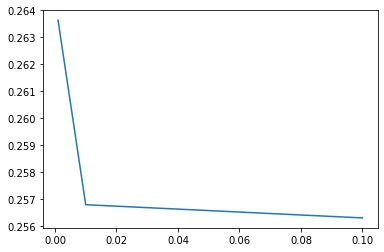

In [ ]:
print("cross validation for LINEAR_LEARNING_RATE")
plt.plot(df_LINEAR_LEARNING_RATE['LINEAR_LEARNING_RATE'], df_LINEAR_LEARNING_RATE['ndcg_MF'])
plt.show()

cross validation for LINEAR_LEARNING_RATE


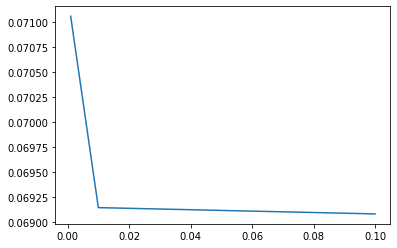

In [ ]:
print("cross validation for LINEAR_LEARNING_RATE")
plt.plot(df_LINEAR_LEARNING_RATE['LINEAR_LEARNING_RATE'], df_LINEAR_LEARNING_RATE['precisionTopK_MF'])
plt.show()

In [ ]:
df_DEEP_LEARNING_RATE = df_cv[(df_cv['dnn_structure_mode']=='[300, 100, 20]')&(df_cv['LINEAR_LEARNING_RATE']==0.001)&(df_cv['LINEAR_L1_STRENGTH']==0)&(df_cv['LINEAR_L2_STRENGTH']==0)]

cross validation for DEEP_LEARNING_RATE


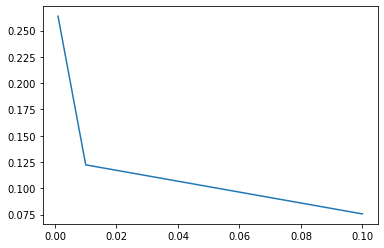

In [ ]:
print("cross validation for DEEP_LEARNING_RATE")
plt.plot(df_DEEP_LEARNING_RATE['DEEP_LEARNING_RATE'], df_DEEP_LEARNING_RATE['ndcg_MF'])
plt.show()

cross validation for DEEP_LEARNING_RATE


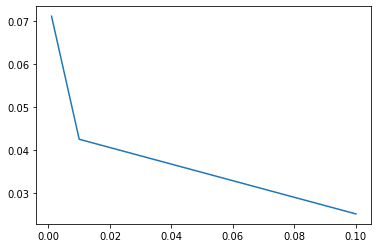

In [ ]:
print("cross validation for DEEP_LEARNING_RATE")
plt.plot(df_DEEP_LEARNING_RATE['DEEP_LEARNING_RATE'], df_DEEP_LEARNING_RATE['precisionTopK_MF'])
plt.show()

In [ ]:
df_LINEAR_L1_STRENGTH = df_cv[(df_cv['dnn_structure_mode']=='[300, 100, 20]')&(df_cv['LINEAR_LEARNING_RATE']==0.001)&(df_cv['DEEP_LEARNING_RATE']==0.001)&(df_cv['LINEAR_L2_STRENGTH']==0)]

cross validation for LINEAR_L1_STRENGTH


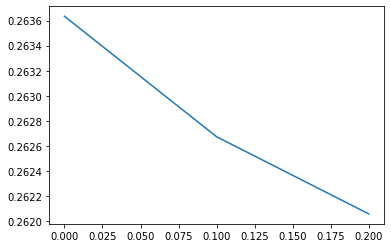

In [ ]:
print("cross validation for LINEAR_L1_STRENGTH")
plt.plot(df_LINEAR_L1_STRENGTH['LINEAR_L1_STRENGTH'], df_LINEAR_L1_STRENGTH['ndcg_MF'])
plt.show()

cross validation for LINEAR_L1_STRENGTH


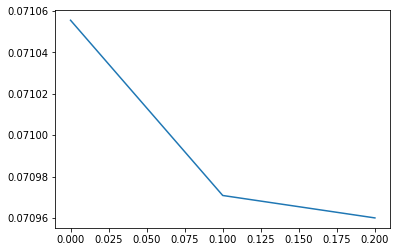

In [ ]:
print("cross validation for LINEAR_L1_STRENGTH")
plt.plot(df_LINEAR_L1_STRENGTH['LINEAR_L1_STRENGTH'], df_LINEAR_L1_STRENGTH['precisionTopK_MF'])
plt.show()

In [ ]:
df_dnn_structure_mode = df_cv[(df_cv['LINEAR_LEARNING_RATE']==0.001)&(df_cv['DEEP_LEARNING_RATE']==0.001)&(df_cv['LINEAR_L1_STRENGTH']==0)&(df_cv['LINEAR_L2_STRENGTH']==0)]

cross validation for DNN STRUCTURES


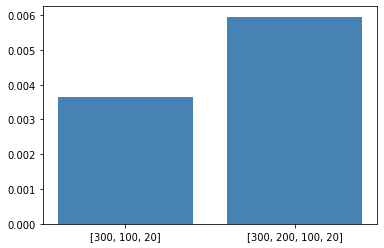

In [ ]:
print("cross validation for DNN STRUCTURES")
plt.bar(x=[0,1], height=df_dnn_structure_mode['ndcg_MF']-0.26,tick_label = df_dnn_structure_mode['dnn_structure_mode'], color = 'steelblue')  #指定条形图的填充色)
plt.show()

cross validation for DNN STRUCTURES


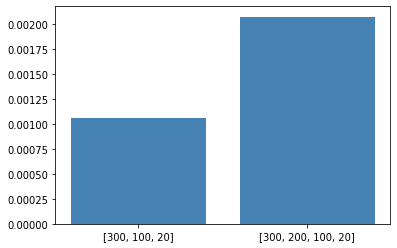

In [ ]:
print("cross validation for DNN STRUCTURES")
plt.bar(x=[0,1], height=df_dnn_structure_mode['precisionTopK_MF']-0.07,tick_label = df_dnn_structure_mode['dnn_structure_mode'], color = 'steelblue')  #指定条形图的填充色)
plt.show()

# Whole pipeline of new hybrid system

For easy use, we could sequentially call all the class and methods we provided above. The procedure is following: 

## Train/Test split

In [ ]:
train, test = build_train_test_split(larger_dataset)

## Feature Genelization

In [ ]:
feature_df = createUserProfile(train).combine()

## Train lightfm model


In [ ]:
# full_dataset = pd.concat([train, test])
train_coo, test_coo = coo_matrix_transform(full_dataset, train, test, if_develop=False)
dimension = 150
lightfm_model = lightFM(train_coo, train, full_tags, full_genome_scores, full_dataset, dimension, only_popular=False, if_develop=False)
lightfm_model.model_setup()

## Create user and movie embedding

In [ ]:
user_embedding = []
for i in range(len(lightfm_model.origin)):
    user_embedding.append([item.astype('double') for item in lightfm_model.user_embedding[i]])
userembed_lightfm = pd.DataFrame(zip(pd.Series(lightfm_model.origin.index),pd.Series(user_embedding)),columns=["userId","features"])


movie_embedding = []
for i in range(lightfm_model.origin.shape[1]):
    movie_embedding.append([item.astype('double') for item in lightfm_model.movie_embedding[i]])
movieembed_lightfm = pd.DataFrame(zip(pd.Series(lightfm_model.origin.columns),pd.Series(movie_embedding)),columns=["movieId","features"])


user_latent = spark.createDataFrame(
    [(int(tup[0]), Vectors.dense([float(item) for item in tup[1]])) for tup in userembed_lightfm.values], 
    ["userId", "features"]
)
movie_latent = spark.createDataFrame(
    [(int(tup[0]), Vectors.dense([float(item) for item in tup[1]])) for tup in movieembed_lightfm.values], 
    ["movieId", "features"]
)


## Use ann to select items

In [ ]:
brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes", bucketLength=2.0,
                                  numHashTables=5)
ann_model = brp.fit(user_latent)
recommend_pd_df = ann_model.approxSimilarityJoin(user_latent, movie_latent, 5, distCol="distCol")\
    .select(col("datasetA.userId").alias("userId"),
            col("datasetB.movieId").alias("movieId")).toPandas()


## Create features for Wide and Deep

In [ ]:
a = createProfile(train, full_tags, full_genome_scores)
movie_feature = a.movie_feature
user_feature = a.user_feature
user_feature_new = pd.merge(user_feature, feature_df, how='inner', left_index=True, right_index=True)
LABEL_COLUMN = 'rating'
CATEGORICAL_COLUMNS = ['userId','movieId','rating_genre_most',"recent_title",'movie_age_most','most_rating_tag','recent_rating_tag']
CONTINUOUS_COLUMNS = [ 'tag_per_user','rating_count', 'rating_mean', 'rating_std', 'rating_min',
       'rating_max', 'participate_age',
       'participate_last','participate_last',
       'movie_year_mean', 'movie_year_std', 'movie_year_min', 'movie_year_max','1970s',
       '1980s', '1990s', '2000s', '2020s', 'ls1970','genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Children',
       'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama',
       'genre_Fantasy', 'genre_Horror', 'genre_Thriller' ]

# Read the training and test data sets into Pandas dataframe.
user_feature_new[CONTINUOUS_COLUMNS] = user_feature_new[CONTINUOUS_COLUMNS].fillna(0)
user_feature_new[['rating_genre_most',"recent_title",'movie_age_most','most_rating_tag','recent_rating_tag']]= user_feature_new[['rating_genre_most',"recent_title",'movie_age_most','most_rating_tag','recent_rating_tag']].fillna('No Information')

# preparing for the tensors
recent_title_voclist = user_feature_new.recent_title.unique().tolist()
recent_rating_tag_voclist = user_feature_new.recent_rating_tag.unique().tolist()
most_rating_tag_voclist = user_feature_new.most_rating_tag.unique().tolist()
movie_age_most_voclist = user_feature_new.movie_age_most.unique().tolist()
# use feature_voclist to define categorical feature range
feature_voclist = dict()
feature_voclist['recent_title'] = recent_title_voclist
feature_voclist['recent_rating_tag'] = recent_rating_tag_voclist
feature_voclist['most_rating_tag'] = most_rating_tag_voclist
feature_voclist['movie_age_most'] = movie_age_most_voclist

movie_feature_new = movie_feature
user_feature_new.reset_index(inplace=True)
user_feature_new.userId = user_feature_new.userId.astype(int)
movie_feature_new.reset_index(inplace=True)
movie_feature_new.rename(columns={
                         'rating_mean': 'rating_mean_movie', 'rating_std': 'rating_std_movie'}, inplace=True)

# remove the cat features ['rated_last', 'rated_first', 'rating_duration']
movie_feature_new = movie_feature_new[['movieId', 'tag_per_movie', 'genre_per_movie', 'tagId',
       'rating_per_movie', 'highest_rating', 'lowest_rating',
       'rating_mean_movie', 'rating_std_movie']].fillna(0)
movie_feature_new.movieId = movie_feature_new.movieId.astype(int)

## Trainning Wide & Deep

In [ ]:
wnd_model = wide_and_deep(user_latent=user_latent,
                          movie_latent=movie_latent,
                          feature_voclist=feature_voclist,
                          user_feature=user_feature_new,
                          movie_feature=movie_feature_new,
                          recommendation_df=recommend_pd_df)

# train model with train data
wnd_model.train(train)

# evaluate model
wnd_estimator.evaluate(test)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/b6/yskn7_x90g94dyfzmm_5tzt00000gn/T/tmpgxtiecpi', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fceee5ea590>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions

INFO:tensorflow:loss = 0.9390221, step = 3300 (20.316 sec)
INFO:tensorflow:global_step/sec: 4.81117
INFO:tensorflow:loss = 0.89473325, step = 3400 (20.787 sec)
INFO:tensorflow:global_step/sec: 4.6931
INFO:tensorflow:loss = 0.9617078, step = 3500 (21.309 sec)
INFO:tensorflow:global_step/sec: 4.78554
INFO:tensorflow:loss = 1.248924, step = 3600 (20.894 sec)
INFO:tensorflow:global_step/sec: 4.8093
INFO:tensorflow:loss = 0.99524754, step = 3700 (20.793 sec)
INFO:tensorflow:Saving checkpoints for 3750 into /var/folders/b6/yskn7_x90g94dyfzmm_5tzt00000gn/T/tmpgxtiecpi/model.ckpt.
INFO:tensorflow:Loss for final step: 0.96690035.
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='flo

## Predict Test Data (batch user recommendation) with Wide and Deep Model

In [ ]:
rc_reorder, actual_df_hybrid, rec_list_hybrid = wnd_estimator.predict(recommend_pd_df, test)

## Evaluation of hybrid Model

In [ ]:
rankingEvaluator = RankingEvaluator(k=50)
ratings_train = create_dataframe(train)
ratings_test = create_dataframe(test)
ndcg_hybrid, precisionTopK_hybrid = rankingEvaluator._evaluate(
    ratings_test, rc_reorder, ratings_train)

print("NDCG is {} and precision is {}".format(ndcg_hybrid, precisionTopK_hybrid))

NDCG is 0.24549026978431873 and precision is 0.06270039187744925


In [ ]:
# generating rec list for userId 408
userId = 408
use_case_embedding = user_latent.where(
    user_latent.userId == userId).select('features').collect()
candidates = model.approxNearestNeighbors(
    movie_latent, use_case_embedding[0][0], 100).select('movieId').collect()
candidates = [item[0] for item in candidates]
recommend_pd_df = pd.DataFrame([pd.Series(
    [userId]*100), pd.Series(candidates)]).T.rename(columns={0: 'userId', 1: 'movieId'})
rc_reorder, _, _ = wnd_estimator.predict(recommend_pd_df, test)
print(rc_reorder.collect())

# Model Comparision

Plot the metrics comparasion for baseline models and new system . 

In [ ]:
def prepare_metrices_para(dataset):
    catalog = dataset.movieId.unique().tolist()
    nov = dataset.movieId.value_counts()
    pop = dict(nov)
    users_number=dataset.userId.nunique()
    return catalog,pop,users_number
    
catalog, pop, users_number = prepare_metrices_para(larger_dataset)

In [ ]:
model_names = [ 'Collaborative Filter - item-based CF','Collaborative Filter - model-based CF','Hybrid sequence recommendation system']


In [ ]:
metric_present_itemCF = metricPresent(itemcf_model.predicted,
                                      pop, users_number, 50, catalog,
                                      movieembed_lightfm.set_index(['movieId']),
                                      itemcf_model.pos_item)

In [ ]:
metric_present_MF = metricPresent(rec_list_MF,
                                  pop, users_number, 50, catalog,
                                  movieembed_lightfm.set_index(['movieId']),
                                  actual_list_MF)

In [ ]:
metric_present_hybrid = metricPresent(rec_list_hybrid,
                                      pop, users_number, 50, catalog,
                                      movieembed_lightfm.set_index(['movieId']),
                                      actual_list_hybrid)

In [ ]:
NDCG_scores = [ndcg_itemcf, ndcg_MF, ndcg_hybrid]
precisionTopk_scores = [precisionTopK_itemcf,
                        precisionTopK_MF, precisionTopK_hybrid]
novelty_scores = [metric_present_itemCF.novelty[0],
                  metric_present_MF.novelty[0], metric_present_hybrid.novelty[0]]
personalization_scores = [metric_present_itemCF.personalization,
                          metric_present_MF.personalization, metric_present_hybrid.personalization]
diversity = [1-metric_present_itemCF.intra_list_similarity, 1 -
             metric_present_MF.intra_list_similarity, 1-metric_present_hybrid.intra_list_similarity]
user_coverage_scores = [metric_present_itemCF.user_coverage,
                        metric_present_MF.user_coverage, metric_present_hybrid.user_coverage]
coverage_scores = [metric_present_itemCF.prediction_coverage,
                   metric_present_MF.prediction_coverage, metric_present_hybrid.prediction_coverage]

In [ ]:
metric_plot = metricPlot(model_names, NDCG_scores, precisionTopk_scores,
                         coverage_scores, user_coverage_scores, personalization_scores,
                         novelty_scores, diversity)

With the best parameters, the metics we got here are:

 * NDCG and Precision @ K

  Based on the hybrid model, NDCG and precision which are our key metrics performs dramatically better than baseline models. So the sequence model with powerful reorder model could significantly improve user experience.
 * Novelty. 
  
  New system will achieve extremly higher performance in exploring novelty for our valuable members. Which is one of our main goals in setting up this project.By combining content information for movie and user, their profiles help us to better match.

* Personalization.
  Three models all could do personalized recommendations. And MF and new system could achieve 100% personalization scores. 


 * Diversity.  

  Our model and MF will achieve similar and higher diversity based on embedding space defined by lightFM. 
 * User coverage. 
  
  Compared with MF, we might not achieve thats higher user coverage. The potential reason could be from we have trade-off between efficiency and user coverage. We utilized ANN so we only have candidates movie set which is significantly smaller than whole movie dataset. 
  But it sitll is higher than item-CF model.

Overall speeking, by seeing the radar chart in the end, we could see the new sequential hybrid model could beat baseline models in several aspects. 


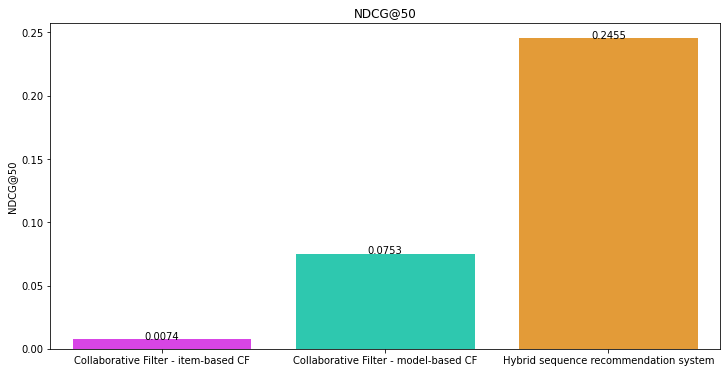

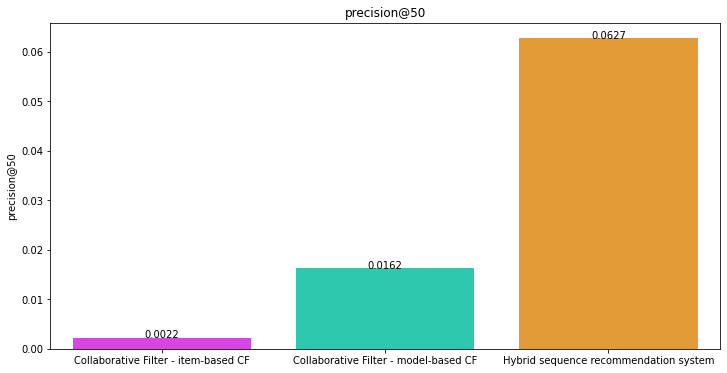

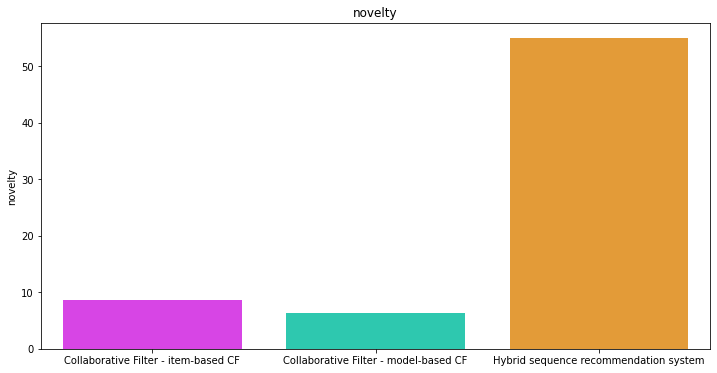

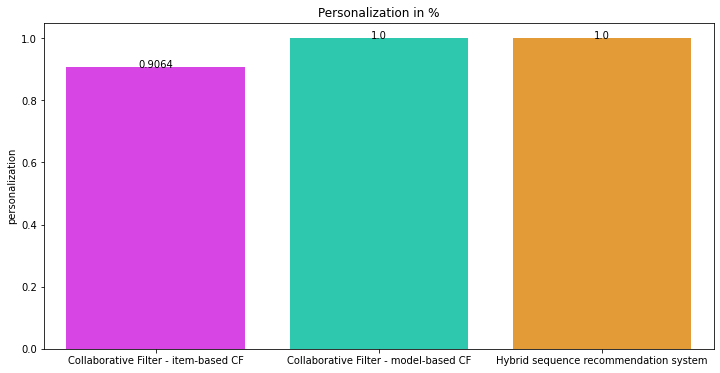

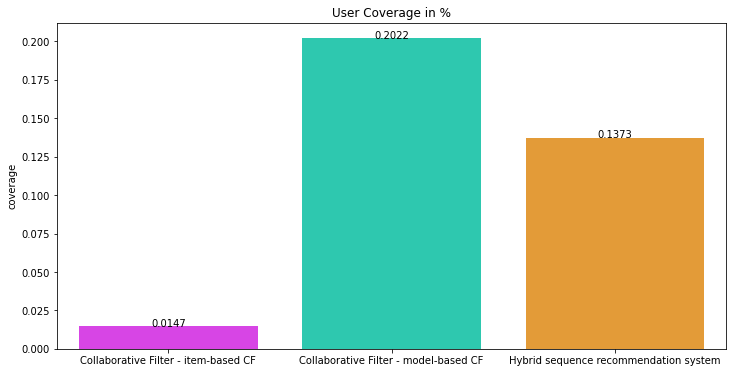

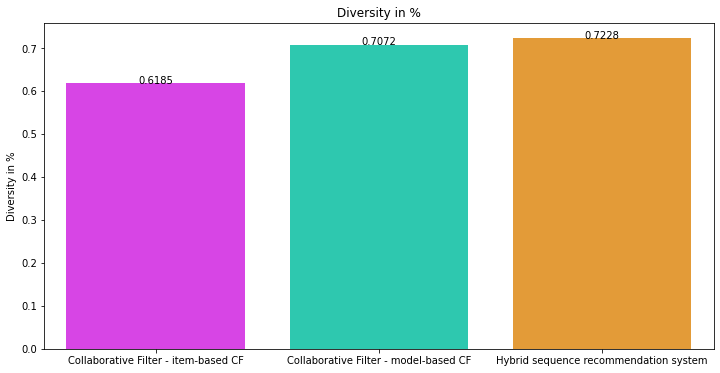

In [ ]:
metric_plot.NDCG_plot
metric_plot.precisionTopk_plot
metric_plot.novelty_plot
metric_plot.personalization_plot
metric_plot.user_coverage_plot
metric_plot.intra_list_similarity_plot
metric_plot.metrics_plot

# Use case : Online presentting final recommendation for a single user


We select user 408 as our example to visualize the recommendation movies list.
We exclude the unpopular items in final recommendation. 

In online recommendation, we fit the user-movie pairs where movies are from candidates set we generated from ANN, along with the user and movie profile. So this re-order will be faster than retrieving from the whole movie set.
Usually we would recommend for batch users just like the procedure we used for evaluation, but also we provide api for recommend for single user.



In [ ]:
# select userId
userId = 408

# extract its embedding vector
use_case_embedding = user_latent.where(
    user_latent.userId == userId).select('features').collect()

# find candidates movies set
candidates = model.approxNearestNeighbors(
    movie_latent, use_case_embedding[0][0], 100).select('movieId').collect()
candidates = [item[0] for item in candidates]

# reconstruct the dataframe
recommend_pd_df = pd.DataFrame([pd.Series(
    [userId]*100), pd.Series(candidates)]).T.rename(columns={0: 'userId', 1: 'movieId'})
    
# present the final movie recommendation list
rc_reorder, _, _ = wnd_estimator.predict(recommend_pd_df, test)

In [ ]:
unpopular_list = MatrixFactorization.getUnpopularList(ratings_train)

# only recommend movies with popularity higher than 10, and exclude movies he/she has rated
def final_recommendation(userId,k=50):
    rec_list=rc_reorder[0]
    exclude_watched_item = ratings_train.filter(ratings_test.userId==93773).select('movieId').agg(expr('collect_list(movieId) as movieId')).collect()
    rec=[item for item in rec_list if item not in exclude_watched_item and item not in unpopular_list][:k] 
    return rec
    
reclist=np.array(final_recommendation(userId,k=50))

In [ ]:
movies_name = larger_dataset[['movieId','title','genres']].copy()
movies_name.drop_duplicates("movieId", inplace=True)
movies_name.set_index("movieId", inplace=True, drop=True)

In [ ]:
print('MF model recommendation for user: ', userId) 
movies_name.loc[np.array(reclist)]

MF model recommendation for user:  93773


,title,genres
movieId,,
106503,"Enemies of Reason, The (2007)",Documentary
137904,"I, Claudius (1976)",Drama
750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
135867,Rabbit Fire (1951),Animation|Children|Comedy
26086,"Occurrence at Owl Creek Bridge, An (La rivière...",Drama|War
49085,"Big City, The (Mahanagar) (1963)",Drama
101964,Mugabe and the White African (2009),Documentary
97673,56 Up (2012),Documentary
53774,"Mystery of Picasso, The (Le mystère Picasso) (...",Documentary
